# Diffusion modeling

In [1]:
import warnings
import numpy as np

warnings.filterwarnings("ignore")

The proposed method requires inferring a motion-less, reference DW map for a given diffusion orientation for which we want to estimate the misalignment.
Inference of the reference map is achieved by first fitting some diffusion model (which we will draw from [DIPY](https://dipy.org)) using all data, except the particular DW map that is to be aligned.
This data splitting scheme was introduced in {doc}`the LOGO splitter section in Introduction to dMRI data <data>`.

All models are required to offer the same API (application programmer interface):

1. The initialization takes a DIPY `GradientTable` as the first argument, and then arbitrary parameters as keyword arguments.
2. A `fit(data)` method, which only requires a positional argument `data`, a 4D array with DWI data.
3. A `predict(gradient_table)` method, which only requires a `GradientTable` as input.
   This method produces a prediction of the signal for every voxel in every direction represented in the input `gradient_table`.

```{attention}
By default, the code running in each Jupyter notebook is its own process.
We must reload the dataset again to use it in this notebook.
```

In [2]:
from eddymotion.data.dmri import DWI
from eddymotion.data.splitting import lovo_split as logo_split
from eddymotion.viz import plot_dwi
dmri_dataset = DWI.from_filename("../../data/dwi.h5")

## Implementing a trivial model

We will first start implementing a *trivial* model.
This model will always return the reference *b=0* map, regardless of the particular diffusion orientation model.
In other words, it is just a ***constant*** model.

Its simplicity does not diminish its great usefulness.
First, when coding it is very important to build up iteratively in complexity.
This model will allow to easily test the overall integration of the different components of our head-motion estimation algorithm.
Also, this model will allow a very straightforward implementation of registration to the *b=0* reference, which is commonly used to initialize the head-motion estimation parameters.

In [3]:
class TrivialB0Model:
    """
    A trivial model that returns a *b=0* map always.

    Implements the interface of :obj:`dipy.reconst.base.ReconstModel`.
    Instead of inheriting from the abstract base, this implementation
    follows type adaptation principles, as it is easier to maintain
    and to read (see https://www.youtube.com/watch?v=3MNVP9-hglc).

    """

    __slots__ = ("_S0",)

    def __init__(self, gtab, S0=None, **kwargs):
        """Implement object initialization."""
        if S0 is None:
            raise ValueError("S0 must be provided")

        self._S0 = S0

    def fit(self, *args, **kwargs):
        """Do nothing."""

    def predict(self, gradient, **kwargs):
        """Return the *b=0* map."""
        return self._S0

The model can easily be initialized as follows (assuming we still have our dataset loaded):

In [4]:
model = TrivialB0Model(
    dmri_dataset.gradients,
    S0=dmri_dataset.bzero,
)

Then, at each iteration of our estimation strategy, we will fit this model to the data, after holding one particular direction (`data_test`) out, using the `logo_split` method of the dataset. In every iteration, this finds the b=0 volumes in the data and averages their values in every voxel:

In [5]:
data_train, data_test = logo_split(dmri_dataset, 10)
model.fit(np.squeeze(data_train[0]))

Finally, we can generate our registration reference with the `predict()` method:

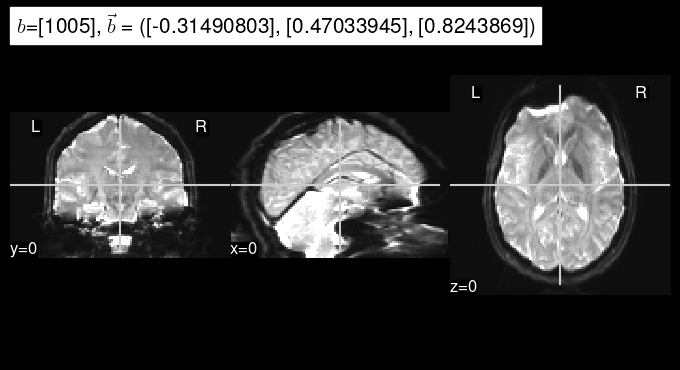

In [6]:
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1]);

As expected, the *b=0* doesn't look very much like the particular left-out direction, but it is a start!

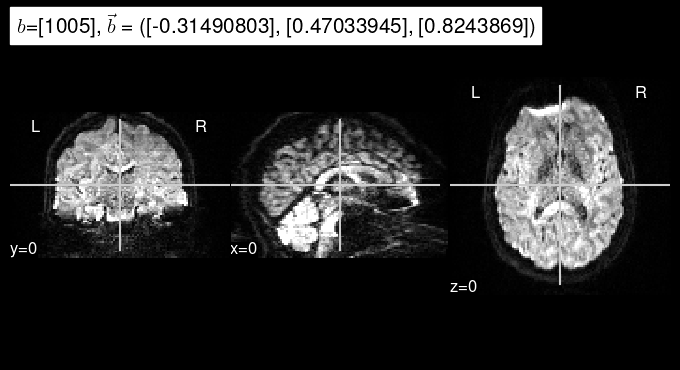

In [7]:
plot_dwi(np.squeeze(data_test[0]), dmri_dataset.affine, gradient=data_test[1]);

## Implementing a *regression to the mean* model

```{admonition} Exercise
Extend the `TrivialB0Model` to produce an average of *all other* diffusion directions, instead of the *b=0*.
```

In [8]:
class AverageDWModel:
    """A trivial model that returns an average map."""

    __slots__ = ("_data",)

    def __init__(self, gtab, **kwargs):
        """Implement object initialization."""
        return  # do nothing at initialization time

    def fit(self, data, **kwargs):
        """Calculate the average."""
        # self._data =  # Use numpy to calculate the average.

    def predict(self, gradient, **kwargs):
        """Return the average map."""
        return self._data

**Solution**

In [9]:
class AverageDWModel:
    """A trivial model that returns an average map."""

    __slots__ = ("_data",)

    def __init__(self, gtab, **kwargs):
        """Implement object initialization."""
        return  # do nothing at initialization time

    def fit(self, data, **kwargs):
        """Calculate the average."""
        self._data =  data.mean(-1)

    def predict(self, gradient, **kwargs):
        """Return the average map."""
        return self._data

```{admonition} Exercise
 Use the new `AverageDWModel` you just created.
```

**Solution**

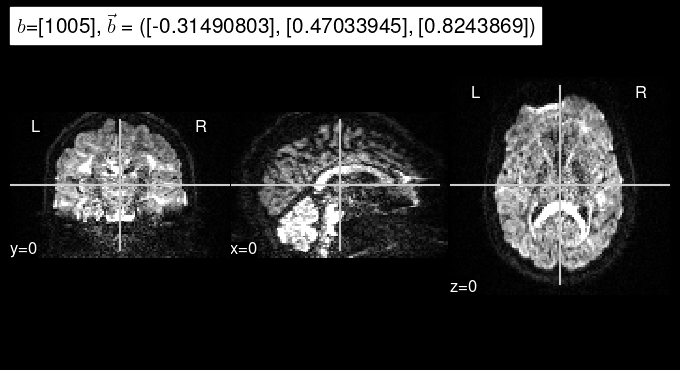

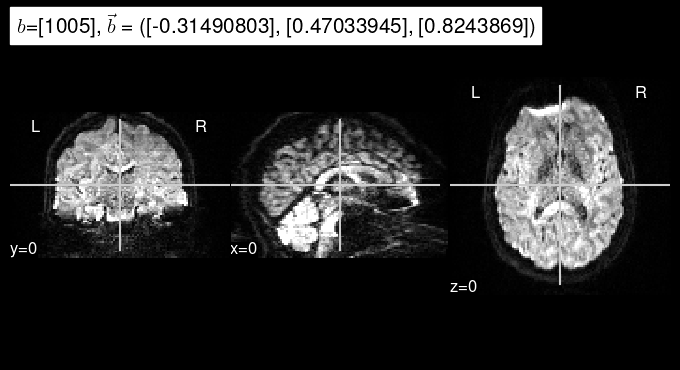

In [10]:
model = AverageDWModel(
    dmri_dataset.gradients,
)
model.fit(data_train[0])
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1]);
plot_dwi(np.squeeze(data_test[0]), dmri_dataset.affine, gradient=data_test[1]);

## Investigating the tensor model

Now, we are ready to use the diffusion tensor model.
We will use the wrap around DIPY's implementation that we distribute with `eddymotion`.

In [11]:
from tempfile import mkstemp
from pathlib import Path
import requests

if dmri_dataset._filepath.exists():
    dmri_dataset._filepath.unlink()
url = "https://files.osf.io/v1/resources/8k95s/providers/osfstorage/6070b4c2f6585f03fb6123a2"
datapath = Path(mkstemp(suffix=".h5")[1])
if datapath.stat().st_size == 0:
    datapath.write_bytes(
        requests.get(url, allow_redirects=True).content
    )

dmri_dataset = DWI.from_filename(datapath)
datapath.unlink()
data_train, data_test = logo_split(dmri_dataset, 88, with_b0=True)

### The model factory

To permit flexibility in selecting models, the `eddymotion` package offers a `ModelFactory` that implements the *facade design pattern*.
This means that `ModelFactory` makes it easier for the user to switch between models:

In [12]:
from eddymotion.model import ModelFactory

# We are using now a full dataset, we need to split the data again

model = ModelFactory.init(
    gtab=data_train[1],
    model="DTI",
    S0=dmri_dataset.bzero,
)

### Leveraging the `fit()` / `predict()` API

The `ModelFactory` returns a model object that is compliant with the interface sketched above:

In [13]:
model.fit(data_train[0])
predicted = model.predict(data_test[1])

Now, the predicted map for the particular ***b*** gradient looks much closer to the original:

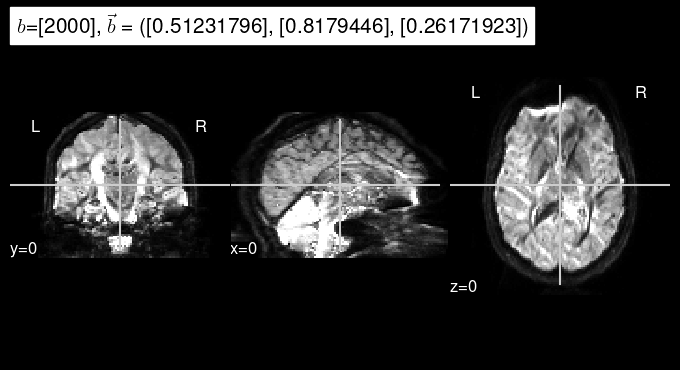

In [14]:
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);

Here's the original DW map, for reference:

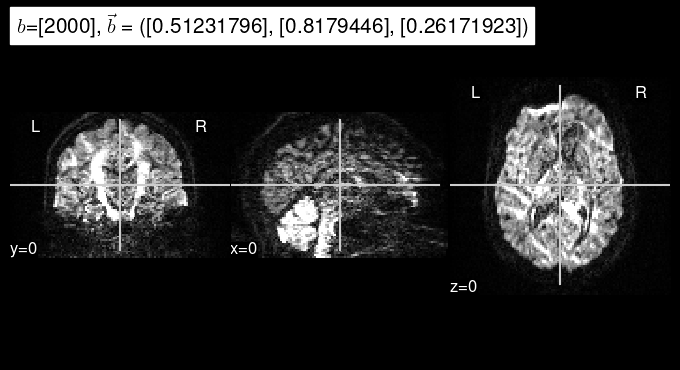

In [15]:
plot_dwi(np.squeeze(data_test[0]), dmri_dataset.affine, gradient=data_test[1]);

```{admonition} Exercise
Use the `ModelFactory` to initialize a `"DKI"` (diffusion Kurtosis imaging) model.
```

**Solution**

In [16]:
model = ModelFactory.init(
    gtab=data_train[1],
    model="DKI",
    S0=dmri_dataset.bzero,
)

Once the model has been initialized, we can easily generate a new prediction.

  0%|          | 0/558210 [00:00<?, ?it/s]

  0%|          | 500/558210 [00:00<01:51, 4996.50it/s]

  0%|          | 1018/558210 [00:00<01:49, 5102.10it/s]

  0%|          | 1539/558210 [00:00<01:48, 5148.57it/s]

  0%|          | 2059/558210 [00:00<01:47, 5166.22it/s]

  0%|          | 2578/558210 [00:00<01:47, 5173.65it/s]

  1%|          | 3096/558210 [00:00<01:48, 5129.76it/s]

  1%|          | 3612/558210 [00:00<01:47, 5136.40it/s]

  1%|          | 4132/558210 [00:00<01:47, 5154.99it/s]

  1%|          | 4653/558210 [00:00<01:47, 5169.31it/s]

  1%|          | 5173/558210 [00:01<01:46, 5178.35it/s]

  1%|          | 5691/558210 [00:01<01:47, 5132.41it/s]

  1%|          | 6205/558210 [00:01<01:47, 5117.65it/s]

  1%|          | 6721/558210 [00:01<01:47, 5128.16it/s]

  1%|▏         | 7239/558210 [00:01<01:47, 5143.09it/s]

  1%|▏         | 7756/558210 [00:01<01:46, 5149.44it/s]

  1%|▏         | 8274/558210 [00:01<01:46, 5156.07it/s]

  2%|▏         | 8791/558210 [00:01<01:46, 5158.28it/s]

  2%|▏         | 9308/558210 [00:01<01:46, 5160.97it/s]

  2%|▏         | 9826/558210 [00:01<01:46, 5166.04it/s]

  2%|▏         | 10345/558210 [00:02<01:45, 5172.83it/s]

  2%|▏         | 10863/558210 [00:02<01:45, 5167.05it/s]

  2%|▏         | 11381/558210 [00:02<01:45, 5167.48it/s]

  2%|▏         | 11898/558210 [00:02<01:45, 5167.34it/s]

  2%|▏         | 12417/558210 [00:02<01:45, 5173.86it/s]

  2%|▏         | 12937/558210 [00:02<01:45, 5180.97it/s]

  2%|▏         | 13458/558210 [00:02<01:45, 5187.07it/s]

  3%|▎         | 13977/558210 [00:02<01:44, 5186.50it/s]

  3%|▎         | 14496/558210 [00:02<01:45, 5177.77it/s]

  3%|▎         | 15014/558210 [00:02<01:45, 5168.61it/s]

  3%|▎         | 15532/558210 [00:03<01:44, 5170.12it/s]

  3%|▎         | 16050/558210 [00:03<01:45, 5139.89it/s]

  3%|▎         | 16566/558210 [00:03<01:45, 5143.44it/s]

  3%|▎         | 17088/558210 [00:03<01:44, 5164.37it/s]

  3%|▎         | 17611/558210 [00:03<01:44, 5181.77it/s]

  3%|▎         | 18134/558210 [00:03<01:43, 5194.78it/s]

  3%|▎         | 18655/558210 [00:03<01:43, 5196.56it/s]

  3%|▎         | 19175/558210 [00:03<01:43, 5197.56it/s]

  4%|▎         | 19698/558210 [00:03<01:43, 5206.03it/s]

  4%|▎         | 20219/558210 [00:03<01:43, 5206.66it/s]

  4%|▎         | 20741/558210 [00:04<01:43, 5207.76it/s]

  4%|▍         | 21265/558210 [00:04<01:42, 5217.37it/s]

  4%|▍         | 21787/558210 [00:04<01:43, 5198.78it/s]

  4%|▍         | 22307/558210 [00:04<01:43, 5194.64it/s]

  4%|▍         | 22827/558210 [00:04<01:43, 5183.57it/s]

  4%|▍         | 23346/558210 [00:04<01:43, 5182.11it/s]

  4%|▍         | 23869/558210 [00:04<01:42, 5195.32it/s]

  4%|▍         | 24392/558210 [00:04<01:42, 5204.47it/s]

  4%|▍         | 24913/558210 [00:04<01:42, 5203.34it/s]

  5%|▍         | 25434/558210 [00:04<01:42, 5201.31it/s]

  5%|▍         | 25958/558210 [00:05<01:42, 5210.51it/s]

  5%|▍         | 26480/558210 [00:05<01:42, 5207.79it/s]

  5%|▍         | 27001/558210 [00:05<01:43, 5150.77it/s]

  5%|▍         | 27520/558210 [00:05<01:42, 5160.99it/s]

  5%|▌         | 28039/558210 [00:05<01:42, 5169.35it/s]

  5%|▌         | 28560/558210 [00:05<01:42, 5179.47it/s]

  5%|▌         | 29079/558210 [00:05<01:42, 5175.27it/s]

  5%|▌         | 29599/558210 [00:05<01:42, 5181.39it/s]

  5%|▌         | 30120/558210 [00:05<01:41, 5189.31it/s]

  5%|▌         | 30641/558210 [00:05<01:41, 5193.85it/s]

  6%|▌         | 31161/558210 [00:06<01:41, 5193.56it/s]

  6%|▌         | 31684/558210 [00:06<01:41, 5202.59it/s]

  6%|▌         | 32205/558210 [00:06<01:42, 5143.57it/s]

  6%|▌         | 32723/558210 [00:06<01:41, 5153.97it/s]

  6%|▌         | 33244/558210 [00:06<01:41, 5167.64it/s]

  6%|▌         | 33763/558210 [00:06<01:41, 5171.35it/s]

  6%|▌         | 34281/558210 [00:06<01:42, 5129.98it/s]

  6%|▌         | 34798/558210 [00:06<01:41, 5139.59it/s]

  6%|▋         | 35313/558210 [00:06<01:41, 5142.49it/s]

  6%|▋         | 35831/558210 [00:06<01:41, 5150.93it/s]

  7%|▋         | 36347/558210 [00:07<01:41, 5146.68it/s]

  7%|▋         | 36865/558210 [00:07<01:41, 5154.47it/s]

  7%|▋         | 37381/558210 [00:07<01:41, 5133.60it/s]

  7%|▋         | 37895/558210 [00:07<01:41, 5119.07it/s]

  7%|▋         | 38407/558210 [00:07<01:41, 5118.56it/s]

  7%|▋         | 38922/558210 [00:07<01:41, 5126.88it/s]

  7%|▋         | 39439/558210 [00:07<01:40, 5138.26it/s]

  7%|▋         | 39954/558210 [00:07<01:40, 5139.62it/s]

  7%|▋         | 40471/558210 [00:07<01:40, 5145.98it/s]

  7%|▋         | 40988/558210 [00:07<01:40, 5151.24it/s]

  7%|▋         | 41504/558210 [00:08<01:40, 5153.61it/s]

  8%|▊         | 42020/558210 [00:08<01:40, 5116.81it/s]

  8%|▊         | 42535/558210 [00:08<01:40, 5124.02it/s]

  8%|▊         | 43050/558210 [00:08<01:40, 5131.16it/s]

  8%|▊         | 43568/558210 [00:08<01:40, 5143.04it/s]

  8%|▊         | 44084/558210 [00:08<01:39, 5146.07it/s]

  8%|▊         | 44599/558210 [00:08<01:39, 5138.07it/s]

  8%|▊         | 45114/558210 [00:08<01:39, 5140.77it/s]

  8%|▊         | 45633/558210 [00:08<01:39, 5153.22it/s]

  8%|▊         | 46152/558210 [00:08<01:39, 5162.15it/s]

  8%|▊         | 46671/558210 [00:09<01:38, 5169.21it/s]

  8%|▊         | 47189/558210 [00:09<01:38, 5172.09it/s]

  9%|▊         | 47707/558210 [00:09<01:39, 5117.41it/s]

  9%|▊         | 48220/558210 [00:09<01:39, 5118.30it/s]

  9%|▊         | 48736/558210 [00:09<01:39, 5129.78it/s]

  9%|▉         | 49252/558210 [00:09<01:39, 5138.69it/s]

  9%|▉         | 49769/558210 [00:09<01:38, 5146.06it/s]

  9%|▉         | 50285/558210 [00:09<01:38, 5149.67it/s]

  9%|▉         | 50800/558210 [00:09<01:39, 5106.68it/s]

  9%|▉         | 51315/558210 [00:09<01:39, 5118.72it/s]

  9%|▉         | 51834/558210 [00:10<01:38, 5138.51it/s]

  9%|▉         | 52352/558210 [00:10<01:38, 5149.33it/s]

  9%|▉         | 52867/558210 [00:10<01:39, 5063.95it/s]

 10%|▉         | 53383/558210 [00:10<01:39, 5092.33it/s]

 10%|▉         | 53906/558210 [00:10<01:38, 5132.17it/s]

 10%|▉         | 54426/558210 [00:10<01:37, 5150.26it/s]

 10%|▉         | 54943/558210 [00:10<01:37, 5155.99it/s]

 10%|▉         | 55461/558210 [00:10<01:37, 5161.63it/s]

 10%|█         | 55980/558210 [00:10<01:37, 5167.84it/s]

 10%|█         | 56497/558210 [00:10<01:37, 5161.18it/s]

 10%|█         | 57015/558210 [00:11<01:37, 5163.50it/s]

 10%|█         | 57535/558210 [00:11<01:36, 5173.72it/s]

 10%|█         | 58054/558210 [00:11<01:36, 5176.89it/s]

 10%|█         | 58573/558210 [00:11<01:36, 5178.00it/s]

 11%|█         | 59096/558210 [00:11<01:36, 5192.19it/s]

 11%|█         | 59616/558210 [00:11<01:35, 5194.52it/s]

 11%|█         | 60139/558210 [00:11<01:35, 5203.37it/s]

 11%|█         | 60661/558210 [00:11<01:35, 5207.04it/s]

 11%|█         | 61182/558210 [00:11<01:35, 5202.09it/s]

 11%|█         | 61705/558210 [00:11<01:35, 5205.90it/s]

 11%|█         | 62226/558210 [00:12<01:35, 5202.51it/s]

 11%|█         | 62747/558210 [00:12<01:35, 5198.13it/s]

 11%|█▏        | 63267/558210 [00:12<01:36, 5145.09it/s]

 11%|█▏        | 63782/558210 [00:12<01:38, 5018.81it/s]

 12%|█▏        | 64288/558210 [00:12<01:38, 5028.71it/s]

 12%|█▏        | 64802/558210 [00:12<01:37, 5058.99it/s]

 12%|█▏        | 65322/558210 [00:12<01:36, 5098.70it/s]

 12%|█▏        | 65841/558210 [00:12<01:36, 5124.65it/s]

 12%|█▏        | 66359/558210 [00:12<01:35, 5140.38it/s]

 12%|█▏        | 66878/558210 [00:12<01:35, 5154.93it/s]

 12%|█▏        | 67397/558210 [00:13<01:35, 5163.49it/s]

 12%|█▏        | 67915/558210 [00:13<01:34, 5167.87it/s]

 12%|█▏        | 68432/558210 [00:13<01:35, 5115.09it/s]

 12%|█▏        | 68949/558210 [00:13<01:35, 5129.52it/s]

 12%|█▏        | 69466/558210 [00:13<01:35, 5140.67it/s]

 13%|█▎        | 69982/558210 [00:13<01:34, 5143.11it/s]

 13%|█▎        | 70499/558210 [00:13<01:34, 5148.63it/s]

 13%|█▎        | 71016/558210 [00:13<01:34, 5152.59it/s]

 13%|█▎        | 71532/558210 [00:13<01:34, 5154.43it/s]

 13%|█▎        | 72051/558210 [00:13<01:34, 5163.20it/s]

 13%|█▎        | 72571/558210 [00:14<01:33, 5172.78it/s]

 13%|█▎        | 73089/558210 [00:14<01:34, 5160.20it/s]

 13%|█▎        | 73606/558210 [00:14<01:34, 5154.66it/s]

 13%|█▎        | 74122/558210 [00:14<01:33, 5153.78it/s]

 13%|█▎        | 74639/558210 [00:14<01:33, 5155.86it/s]

 13%|█▎        | 75155/558210 [00:14<01:33, 5147.27it/s]

 14%|█▎        | 75671/558210 [00:14<01:33, 5150.94it/s]

 14%|█▎        | 76187/558210 [00:14<01:33, 5150.55it/s]

 14%|█▎        | 76703/558210 [00:14<01:33, 5149.14it/s]

 14%|█▍        | 77218/558210 [00:14<01:33, 5147.18it/s]

 14%|█▍        | 77733/558210 [00:15<01:33, 5147.01it/s]

 14%|█▍        | 78251/558210 [00:15<01:33, 5155.77it/s]

 14%|█▍        | 78767/558210 [00:15<01:33, 5102.01it/s]

 14%|█▍        | 79285/558210 [00:15<01:33, 5123.64it/s]

 14%|█▍        | 79804/558210 [00:15<01:33, 5141.28it/s]

 14%|█▍        | 80319/558210 [00:15<01:32, 5139.96it/s]

 14%|█▍        | 80834/558210 [00:15<01:32, 5140.15it/s]

 15%|█▍        | 81349/558210 [00:15<01:32, 5130.08it/s]

 15%|█▍        | 81866/558210 [00:15<01:32, 5140.55it/s]

 15%|█▍        | 82383/558210 [00:15<01:32, 5147.88it/s]

 15%|█▍        | 82901/558210 [00:16<01:32, 5157.49it/s]

 15%|█▍        | 83417/558210 [00:16<01:32, 5156.48it/s]

 15%|█▌        | 83933/558210 [00:16<01:32, 5112.69it/s]

 15%|█▌        | 84452/558210 [00:16<01:32, 5134.66it/s]

 15%|█▌        | 84972/558210 [00:16<01:31, 5152.74it/s]

 15%|█▌        | 85489/558210 [00:16<01:31, 5157.73it/s]

 15%|█▌        | 86010/558210 [00:16<01:31, 5170.69it/s]

 16%|█▌        | 86528/558210 [00:16<01:31, 5173.18it/s]

 16%|█▌        | 87048/558210 [00:16<01:30, 5178.92it/s]

 16%|█▌        | 87566/558210 [00:16<01:30, 5175.14it/s]

 16%|█▌        | 88084/558210 [00:17<01:30, 5175.92it/s]

 16%|█▌        | 88603/558210 [00:17<01:30, 5178.05it/s]

 16%|█▌        | 89121/558210 [00:17<01:30, 5172.55it/s]

 16%|█▌        | 89639/558210 [00:17<01:30, 5156.38it/s]

 16%|█▌        | 90159/558210 [00:17<01:30, 5166.52it/s]

 16%|█▌        | 90676/558210 [00:17<01:55, 4047.63it/s]

 16%|█▋        | 91189/558210 [00:17<01:48, 4317.34it/s]

 16%|█▋        | 91696/558210 [00:17<01:43, 4514.23it/s]

 17%|█▋        | 92210/558210 [00:17<01:39, 4684.46it/s]

 17%|█▋        | 92727/558210 [00:18<01:36, 4819.54it/s]

 17%|█▋        | 93244/558210 [00:18<01:34, 4919.43it/s]

 17%|█▋        | 93747/558210 [00:18<01:33, 4951.37it/s]

 17%|█▋        | 94266/558210 [00:18<01:32, 5020.52it/s]

 17%|█▋        | 94780/558210 [00:18<01:31, 5055.28it/s]

 17%|█▋        | 95295/558210 [00:18<01:31, 5082.90it/s]

 17%|█▋        | 95813/558210 [00:18<01:30, 5109.03it/s]

 17%|█▋        | 96329/558210 [00:18<01:30, 5122.70it/s]

 17%|█▋        | 96848/558210 [00:18<01:29, 5140.77it/s]

 17%|█▋        | 97364/558210 [00:18<01:29, 5129.02it/s]

 18%|█▊        | 97882/558210 [00:19<01:29, 5142.85it/s]

 18%|█▊        | 98399/558210 [00:19<01:29, 5149.24it/s]

 18%|█▊        | 98915/558210 [00:19<01:29, 5144.55it/s]

 18%|█▊        | 99430/558210 [00:19<01:29, 5132.73it/s]

 18%|█▊        | 99948/558210 [00:19<01:29, 5146.03it/s]

 18%|█▊        | 100465/558210 [00:19<01:28, 5151.05it/s]

 18%|█▊        | 100981/558210 [00:19<01:28, 5150.26it/s]

 18%|█▊        | 101497/558210 [00:19<01:28, 5150.24it/s]

 18%|█▊        | 102013/558210 [00:19<01:28, 5143.30it/s]

 18%|█▊        | 102533/558210 [00:19<01:28, 5156.29it/s]

 18%|█▊        | 103052/558210 [00:20<01:28, 5165.59it/s]

 19%|█▊        | 103571/558210 [00:20<01:27, 5172.77it/s]

 19%|█▊        | 104089/558210 [00:20<01:27, 5166.13it/s]

 19%|█▊        | 104606/558210 [00:20<01:28, 5120.65it/s]

 19%|█▉        | 105124/558210 [00:20<01:28, 5138.10it/s]

 19%|█▉        | 105645/558210 [00:20<01:27, 5157.42it/s]

 19%|█▉        | 106164/558210 [00:20<01:27, 5165.04it/s]

 19%|█▉        | 106686/558210 [00:20<01:27, 5179.33it/s]

 19%|█▉        | 107204/558210 [00:20<01:27, 5178.06it/s]

 19%|█▉        | 107725/558210 [00:20<01:26, 5186.65it/s]

 19%|█▉        | 108246/558210 [00:21<01:26, 5192.61it/s]

 19%|█▉        | 108766/558210 [00:21<01:26, 5191.60it/s]

 20%|█▉        | 109286/558210 [00:21<01:26, 5192.16it/s]

 20%|█▉        | 109806/558210 [00:21<01:26, 5175.24it/s]

 20%|█▉        | 110326/558210 [00:21<01:26, 5180.15it/s]

 20%|█▉        | 110847/558210 [00:21<01:26, 5187.64it/s]

 20%|█▉        | 111366/558210 [00:21<01:26, 5178.39it/s]

 20%|██        | 111884/558210 [00:21<01:26, 5173.01it/s]

 20%|██        | 112402/558210 [00:21<01:26, 5172.54it/s]

 20%|██        | 112922/558210 [00:21<01:25, 5180.21it/s]

 20%|██        | 113441/558210 [00:22<01:25, 5183.11it/s]

 20%|██        | 113960/558210 [00:22<01:25, 5182.41it/s]

 21%|██        | 114483/558210 [00:22<01:25, 5195.24it/s]

 21%|██        | 115003/558210 [00:22<01:26, 5132.30it/s]

 21%|██        | 115521/558210 [00:22<01:26, 5144.97it/s]

 21%|██        | 116042/558210 [00:22<01:25, 5162.16it/s]

 21%|██        | 116561/558210 [00:22<01:25, 5168.03it/s]

 21%|██        | 117082/558210 [00:22<01:25, 5177.68it/s]

 21%|██        | 117601/558210 [00:22<01:25, 5180.57it/s]

 21%|██        | 118120/558210 [00:22<01:24, 5181.53it/s]

 21%|██▏       | 118641/558210 [00:23<01:24, 5189.09it/s]

 21%|██▏       | 119160/558210 [00:23<01:24, 5189.21it/s]

 21%|██▏       | 119681/558210 [00:23<01:24, 5194.44it/s]

 22%|██▏       | 120201/558210 [00:23<01:24, 5175.60it/s]

 22%|██▏       | 120723/558210 [00:23<01:24, 5188.01it/s]

 22%|██▏       | 121242/558210 [00:23<01:24, 5179.08it/s]

 22%|██▏       | 121762/558210 [00:23<01:24, 5183.81it/s]

 22%|██▏       | 122281/558210 [00:23<01:24, 5184.77it/s]

 22%|██▏       | 122801/558210 [00:23<01:23, 5188.50it/s]

 22%|██▏       | 123321/558210 [00:23<01:23, 5191.83it/s]

 22%|██▏       | 123841/558210 [00:24<01:23, 5175.47it/s]

 22%|██▏       | 124360/558210 [00:24<01:23, 5177.81it/s]

 22%|██▏       | 124881/558210 [00:24<01:23, 5186.68it/s]

 22%|██▏       | 125400/558210 [00:24<01:24, 5129.07it/s]

 23%|██▎       | 125921/558210 [00:24<01:23, 5151.99it/s]

 23%|██▎       | 126438/558210 [00:24<01:23, 5155.41it/s]

 23%|██▎       | 126958/558210 [00:24<01:23, 5166.90it/s]

 23%|██▎       | 127477/558210 [00:24<01:23, 5171.51it/s]

 23%|██▎       | 127995/558210 [00:24<01:23, 5168.29it/s]

 23%|██▎       | 128512/558210 [00:25<01:23, 5168.02it/s]

 23%|██▎       | 129030/558210 [00:25<01:22, 5171.21it/s]

 23%|██▎       | 129550/558210 [00:25<01:22, 5179.67it/s]

 23%|██▎       | 130070/558210 [00:25<01:22, 5183.78it/s]

 23%|██▎       | 130589/558210 [00:25<01:22, 5153.03it/s]

 23%|██▎       | 131108/558210 [00:25<01:22, 5161.63it/s]

 24%|██▎       | 131626/558210 [00:25<01:22, 5164.46it/s]

 24%|██▎       | 132143/558210 [00:25<01:22, 5153.58it/s]

 24%|██▍       | 132661/558210 [00:25<01:22, 5157.39it/s]

 24%|██▍       | 133181/558210 [00:25<01:22, 5167.90it/s]

 24%|██▍       | 133698/558210 [00:26<01:22, 5166.71it/s]

 24%|██▍       | 134216/558210 [00:26<01:22, 5168.29it/s]

 24%|██▍       | 134735/558210 [00:26<01:21, 5172.48it/s]

 24%|██▍       | 135256/558210 [00:26<01:21, 5181.49it/s]

 24%|██▍       | 135775/558210 [00:26<01:21, 5165.93it/s]

 24%|██▍       | 136293/558210 [00:26<01:21, 5169.25it/s]

 25%|██▍       | 136814/558210 [00:26<01:21, 5180.92it/s]

 25%|██▍       | 137335/558210 [00:26<01:21, 5187.97it/s]

 25%|██▍       | 137856/558210 [00:26<01:20, 5192.66it/s]

 25%|██▍       | 138376/558210 [00:26<01:21, 5178.85it/s]

 25%|██▍       | 138894/558210 [00:27<01:21, 5166.45it/s]

 25%|██▍       | 139413/558210 [00:27<01:20, 5171.28it/s]

 25%|██▌       | 139933/558210 [00:27<01:20, 5177.68it/s]

 25%|██▌       | 140451/558210 [00:27<01:20, 5176.12it/s]

 25%|██▌       | 140969/558210 [00:27<01:20, 5167.99it/s]

 25%|██▌       | 141490/558210 [00:27<01:20, 5179.46it/s]

 25%|██▌       | 142009/558210 [00:27<01:20, 5182.43it/s]

 26%|██▌       | 142528/558210 [00:27<01:20, 5175.04it/s]

 26%|██▌       | 143047/558210 [00:27<01:20, 5175.42it/s]

 26%|██▌       | 143569/558210 [00:27<01:19, 5187.64it/s]

 26%|██▌       | 144088/558210 [00:28<01:19, 5180.78it/s]

 26%|██▌       | 144608/558210 [00:28<01:19, 5183.66it/s]

 26%|██▌       | 145128/558210 [00:28<01:19, 5186.97it/s]

 26%|██▌       | 145648/558210 [00:28<01:19, 5189.32it/s]

 26%|██▌       | 146167/558210 [00:28<01:20, 5123.04it/s]

 26%|██▋       | 146686/558210 [00:28<01:20, 5142.22it/s]

 26%|██▋       | 147203/558210 [00:28<01:19, 5149.69it/s]

 26%|██▋       | 147722/558210 [00:28<01:19, 5161.16it/s]

 27%|██▋       | 148243/558210 [00:28<01:19, 5173.58it/s]

 27%|██▋       | 148761/558210 [00:28<01:19, 5164.79it/s]

 27%|██▋       | 149279/558210 [00:29<01:19, 5166.01it/s]

 27%|██▋       | 149799/558210 [00:29<01:18, 5173.68it/s]

 27%|██▋       | 150317/558210 [00:29<01:18, 5175.36it/s]

 27%|██▋       | 150835/558210 [00:29<01:20, 5045.64it/s]

 27%|██▋       | 151346/558210 [00:29<01:20, 5062.80it/s]

 27%|██▋       | 151864/558210 [00:29<01:19, 5097.04it/s]

 27%|██▋       | 152382/558210 [00:29<01:19, 5121.66it/s]

 27%|██▋       | 152902/558210 [00:29<01:18, 5142.93it/s]

 27%|██▋       | 153417/558210 [00:29<01:18, 5141.81it/s]

 28%|██▊       | 153932/558210 [00:29<01:18, 5144.19it/s]

 28%|██▊       | 154448/558210 [00:30<01:18, 5146.37it/s]

 28%|██▊       | 154965/558210 [00:30<01:18, 5152.98it/s]

 28%|██▊       | 155483/558210 [00:30<01:18, 5158.63it/s]

 28%|██▊       | 156004/558210 [00:30<01:17, 5172.68it/s]

 28%|██▊       | 156522/558210 [00:30<01:18, 5113.33it/s]

 28%|██▊       | 157038/558210 [00:30<01:18, 5124.54it/s]

 28%|██▊       | 157553/558210 [00:30<01:18, 5131.41it/s]

 28%|██▊       | 158072/558210 [00:30<01:17, 5146.93it/s]

 28%|██▊       | 158594/558210 [00:30<01:17, 5166.27it/s]

 29%|██▊       | 159114/558210 [00:30<01:17, 5176.08it/s]

 29%|██▊       | 159635/558210 [00:31<01:16, 5183.35it/s]

 29%|██▊       | 160155/558210 [00:31<01:16, 5185.84it/s]

 29%|██▉       | 160675/558210 [00:31<01:16, 5187.57it/s]

 29%|██▉       | 161194/558210 [00:31<01:16, 5181.97it/s]

 29%|██▉       | 161713/558210 [00:31<01:16, 5174.94it/s]

 29%|██▉       | 162231/558210 [00:31<01:16, 5176.03it/s]

 29%|██▉       | 162750/558210 [00:31<01:16, 5178.85it/s]

 29%|██▉       | 163268/558210 [00:31<01:16, 5178.86it/s]

 29%|██▉       | 163788/558210 [00:31<01:16, 5184.39it/s]

 29%|██▉       | 164307/558210 [00:31<01:16, 5176.52it/s]

 30%|██▉       | 164826/558210 [00:32<01:15, 5176.86it/s]

 30%|██▉       | 165344/558210 [00:32<01:15, 5169.90it/s]

 30%|██▉       | 165864/558210 [00:32<01:15, 5176.51it/s]

 30%|██▉       | 166385/558210 [00:32<01:15, 5186.09it/s]

 30%|██▉       | 166904/558210 [00:32<01:15, 5179.55it/s]

 30%|██▉       | 167424/558210 [00:32<01:15, 5185.31it/s]

 30%|███       | 167945/558210 [00:32<01:15, 5190.50it/s]

 30%|███       | 168466/558210 [00:32<01:15, 5194.56it/s]

 30%|███       | 168987/558210 [00:32<01:14, 5196.40it/s]

 30%|███       | 169508/558210 [00:32<01:14, 5199.77it/s]

 30%|███       | 170028/558210 [00:33<01:14, 5184.70it/s]

 31%|███       | 170550/558210 [00:33<01:14, 5191.90it/s]

 31%|███       | 171070/558210 [00:33<01:14, 5192.24it/s]

 31%|███       | 171591/558210 [00:33<01:14, 5196.53it/s]

 31%|███       | 172111/558210 [00:33<01:14, 5196.05it/s]

 31%|███       | 172631/558210 [00:33<01:14, 5189.66it/s]

 31%|███       | 173150/558210 [00:33<01:14, 5179.30it/s]

 31%|███       | 173668/558210 [00:33<01:14, 5167.61it/s]

 31%|███       | 174185/558210 [00:33<01:14, 5164.64it/s]

 31%|███▏      | 174702/558210 [00:33<01:14, 5160.56it/s]

 31%|███▏      | 175222/558210 [00:34<01:14, 5171.41it/s]

 31%|███▏      | 175743/558210 [00:34<01:13, 5182.22it/s]

 32%|███▏      | 176262/558210 [00:34<01:13, 5176.30it/s]

 32%|███▏      | 176780/558210 [00:34<01:13, 5175.47it/s]

 32%|███▏      | 177300/558210 [00:34<01:13, 5180.94it/s]

 32%|███▏      | 177819/558210 [00:34<01:13, 5167.67it/s]

 32%|███▏      | 178337/558210 [00:34<01:13, 5168.77it/s]

 32%|███▏      | 178860/558210 [00:34<01:13, 5184.50it/s]

 32%|███▏      | 179383/558210 [00:34<01:12, 5197.31it/s]

 32%|███▏      | 179903/558210 [00:34<01:12, 5192.53it/s]

 32%|███▏      | 180423/558210 [00:35<01:12, 5186.16it/s]

 32%|███▏      | 180942/558210 [00:35<01:12, 5183.74it/s]

 33%|███▎      | 181462/558210 [00:35<01:12, 5186.25it/s]

 33%|███▎      | 181981/558210 [00:35<01:12, 5167.96it/s]

 33%|███▎      | 182501/558210 [00:35<01:12, 5175.47it/s]

 33%|███▎      | 183019/558210 [00:35<01:34, 3985.75it/s]

 33%|███▎      | 183540/558210 [00:35<01:27, 4287.51it/s]

 33%|███▎      | 184057/558210 [00:35<01:22, 4517.07it/s]

 33%|███▎      | 184576/558210 [00:35<01:19, 4699.62it/s]

 33%|███▎      | 185090/558210 [00:36<01:17, 4822.63it/s]

 33%|███▎      | 185607/558210 [00:36<01:15, 4920.58it/s]

 33%|███▎      | 186127/558210 [00:36<01:14, 4998.81it/s]

 33%|███▎      | 186648/558210 [00:36<01:13, 5058.38it/s]

 34%|███▎      | 187168/558210 [00:36<01:12, 5099.60it/s]

 34%|███▎      | 187683/558210 [00:36<01:13, 5067.96it/s]

 34%|███▎      | 188195/558210 [00:36<01:12, 5083.01it/s]

 34%|███▍      | 188712/558210 [00:36<01:12, 5106.76it/s]

 34%|███▍      | 189231/558210 [00:36<01:11, 5130.48it/s]

 34%|███▍      | 189748/558210 [00:36<01:11, 5140.13it/s]

 34%|███▍      | 190266/558210 [00:37<01:11, 5150.81it/s]

 34%|███▍      | 190784/558210 [00:37<01:11, 5157.14it/s]

 34%|███▍      | 191305/558210 [00:37<01:10, 5172.78it/s]

 34%|███▍      | 191826/558210 [00:37<01:10, 5182.05it/s]

 34%|███▍      | 192346/558210 [00:37<01:10, 5184.72it/s]

 35%|███▍      | 192865/558210 [00:37<01:10, 5154.61it/s]

 35%|███▍      | 193382/558210 [00:37<01:10, 5158.16it/s]

 35%|███▍      | 193903/558210 [00:37<01:10, 5172.80it/s]

 35%|███▍      | 194423/558210 [00:37<01:10, 5180.72it/s]

 35%|███▍      | 194944/558210 [00:37<01:10, 5187.14it/s]

 35%|███▌      | 195463/558210 [00:38<01:09, 5183.29it/s]

 35%|███▌      | 195982/558210 [00:38<01:10, 5159.49it/s]

 35%|███▌      | 196499/558210 [00:38<01:10, 5161.65it/s]

 35%|███▌      | 197018/558210 [00:38<01:09, 5169.42it/s]

 35%|███▌      | 197537/558210 [00:38<01:09, 5172.79it/s]

 35%|███▌      | 198055/558210 [00:38<01:09, 5174.29it/s]

 36%|███▌      | 198573/558210 [00:38<01:09, 5171.02it/s]

 36%|███▌      | 199095/558210 [00:38<01:09, 5183.86it/s]

 36%|███▌      | 199614/558210 [00:38<01:09, 5159.26it/s]

 36%|███▌      | 200132/558210 [00:38<01:09, 5162.75it/s]

 36%|███▌      | 200649/558210 [00:39<01:09, 5163.47it/s]

 36%|███▌      | 201166/558210 [00:39<01:09, 5151.70it/s]

 36%|███▌      | 201686/558210 [00:39<01:09, 5163.59it/s]

 36%|███▌      | 202206/558210 [00:39<01:08, 5173.12it/s]

 36%|███▋      | 202726/558210 [00:39<01:08, 5178.18it/s]

 36%|███▋      | 203244/558210 [00:39<01:09, 5121.38it/s]

 37%|███▋      | 203765/558210 [00:39<01:08, 5145.97it/s]

 37%|███▋      | 204284/558210 [00:39<01:08, 5156.37it/s]

 37%|███▋      | 204800/558210 [00:39<01:08, 5154.70it/s]

 37%|███▋      | 205320/558210 [00:39<01:08, 5165.77it/s]

 37%|███▋      | 205841/558210 [00:40<01:08, 5176.11it/s]

 37%|███▋      | 206362/558210 [00:40<01:07, 5185.36it/s]

 37%|███▋      | 206881/558210 [00:40<01:07, 5183.49it/s]

 37%|███▋      | 207402/558210 [00:40<01:07, 5188.82it/s]

 37%|███▋      | 207921/558210 [00:40<01:07, 5173.95it/s]

 37%|███▋      | 208439/558210 [00:40<01:07, 5173.14it/s]

 37%|███▋      | 208957/558210 [00:40<01:07, 5171.53it/s]

 38%|███▊      | 209475/558210 [00:40<01:07, 5164.34it/s]

 38%|███▊      | 209996/558210 [00:40<01:07, 5176.63it/s]

 38%|███▊      | 210519/558210 [00:40<01:06, 5190.02it/s]

 38%|███▊      | 211039/558210 [00:41<01:06, 5190.73it/s]

 38%|███▊      | 211559/558210 [00:41<01:06, 5190.85it/s]

 38%|███▊      | 212080/558210 [00:41<01:06, 5195.30it/s]

 38%|███▊      | 212600/558210 [00:41<01:06, 5196.58it/s]

 38%|███▊      | 213120/558210 [00:41<01:06, 5184.85it/s]

 38%|███▊      | 213639/558210 [00:41<01:06, 5175.17it/s]

 38%|███▊      | 214160/558210 [00:41<01:06, 5183.61it/s]

 38%|███▊      | 214679/558210 [00:41<01:10, 4881.04it/s]

 39%|███▊      | 215171/558210 [00:41<01:12, 4704.68it/s]

 39%|███▊      | 215687/558210 [00:42<01:10, 4831.42it/s]

 39%|███▊      | 216202/558210 [00:42<01:09, 4921.46it/s]

 39%|███▉      | 216721/558210 [00:42<01:08, 4997.21it/s]

 39%|███▉      | 217240/558210 [00:42<01:07, 5053.11it/s]

 39%|███▉      | 217761/558210 [00:42<01:06, 5097.74it/s]

 39%|███▉      | 218281/558210 [00:42<01:06, 5125.32it/s]

 39%|███▉      | 218801/558210 [00:42<01:05, 5145.76it/s]

 39%|███▉      | 219317/558210 [00:42<01:05, 5148.27it/s]

 39%|███▉      | 219839/558210 [00:42<01:05, 5167.50it/s]

 39%|███▉      | 220359/558210 [00:42<01:05, 5174.22it/s]

 40%|███▉      | 220877/558210 [00:43<01:05, 5162.84it/s]

 40%|███▉      | 221398/558210 [00:43<01:05, 5173.36it/s]

 40%|███▉      | 221917/558210 [00:43<01:04, 5176.56it/s]

 40%|███▉      | 222436/558210 [00:43<01:04, 5179.92it/s]

 40%|███▉      | 222955/558210 [00:43<01:04, 5177.56it/s]

 40%|████      | 223476/558210 [00:43<01:04, 5186.62it/s]

 40%|████      | 223995/558210 [00:43<01:04, 5162.81it/s]

 40%|████      | 224512/558210 [00:43<01:04, 5163.69it/s]

 40%|████      | 225032/558210 [00:43<01:04, 5173.54it/s]

 40%|████      | 225551/558210 [00:43<01:04, 5177.33it/s]

 40%|████      | 226071/558210 [00:44<01:04, 5181.25it/s]

 41%|████      | 226595/558210 [00:44<01:03, 5198.05it/s]

 41%|████      | 227116/558210 [00:44<01:03, 5199.11it/s]

 41%|████      | 227638/558210 [00:44<01:03, 5205.30it/s]

 41%|████      | 228159/558210 [00:44<01:03, 5202.19it/s]

 41%|████      | 228680/558210 [00:44<01:03, 5201.75it/s]

 41%|████      | 229201/558210 [00:44<01:03, 5201.01it/s]

 41%|████      | 229722/558210 [00:44<01:03, 5188.21it/s]

 41%|████      | 230242/558210 [00:44<01:03, 5191.46it/s]

 41%|████▏     | 230762/558210 [00:44<01:03, 5194.00it/s]

 41%|████▏     | 231282/558210 [00:45<01:02, 5190.91it/s]

 42%|████▏     | 231803/558210 [00:45<01:02, 5194.94it/s]

 42%|████▏     | 232324/558210 [00:45<01:02, 5199.07it/s]

 42%|████▏     | 232844/558210 [00:45<01:02, 5185.75it/s]

 42%|████▏     | 233363/558210 [00:45<01:02, 5181.99it/s]

 42%|████▏     | 233884/558210 [00:45<01:02, 5188.91it/s]

 42%|████▏     | 234403/558210 [00:45<01:02, 5189.13it/s]

 42%|████▏     | 234922/558210 [00:45<01:02, 5188.05it/s]

 42%|████▏     | 235446/558210 [00:45<01:02, 5201.20it/s]

 42%|████▏     | 235969/558210 [00:45<01:01, 5209.46it/s]

 42%|████▏     | 236491/558210 [00:46<01:01, 5211.12it/s]

 42%|████▏     | 237014/558210 [00:46<01:01, 5214.09it/s]

 43%|████▎     | 237536/558210 [00:46<01:01, 5209.86it/s]

 43%|████▎     | 238057/558210 [00:46<01:01, 5208.02it/s]

 43%|████▎     | 238578/558210 [00:46<01:01, 5200.58it/s]

 43%|████▎     | 239100/558210 [00:46<01:01, 5205.35it/s]

 43%|████▎     | 239621/558210 [00:46<01:01, 5194.66it/s]

 43%|████▎     | 240141/558210 [00:46<01:01, 5193.31it/s]

 43%|████▎     | 240661/558210 [00:46<01:01, 5187.86it/s]

 43%|████▎     | 241180/558210 [00:46<01:01, 5177.46it/s]

 43%|████▎     | 241698/558210 [00:47<01:01, 5176.70it/s]

 43%|████▎     | 242218/558210 [00:47<01:00, 5181.60it/s]

 43%|████▎     | 242737/558210 [00:47<01:00, 5174.95it/s]

 44%|████▎     | 243255/558210 [00:47<01:00, 5170.50it/s]

 44%|████▎     | 243778/558210 [00:47<01:00, 5186.17it/s]

 44%|████▍     | 244301/558210 [00:47<01:00, 5198.19it/s]

 44%|████▍     | 244821/558210 [00:47<01:00, 5185.22it/s]

 44%|████▍     | 245340/558210 [00:47<01:00, 5163.25it/s]

 44%|████▍     | 245860/558210 [00:47<01:00, 5171.15it/s]

 44%|████▍     | 246378/558210 [00:47<01:00, 5173.00it/s]

 44%|████▍     | 246897/558210 [00:48<01:00, 5176.25it/s]

 44%|████▍     | 247417/558210 [00:48<00:59, 5182.95it/s]

 44%|████▍     | 247936/558210 [00:48<00:59, 5180.09it/s]

 45%|████▍     | 248455/558210 [00:48<00:59, 5178.88it/s]

 45%|████▍     | 248973/558210 [00:48<00:59, 5178.66it/s]

 45%|████▍     | 249491/558210 [00:48<00:59, 5163.28it/s]

 45%|████▍     | 250008/558210 [00:48<00:59, 5158.18it/s]

 45%|████▍     | 250525/558210 [00:48<00:59, 5159.46it/s]

 45%|████▍     | 251047/558210 [00:48<00:59, 5175.34it/s]

 45%|████▌     | 251570/558210 [00:48<00:59, 5189.30it/s]

 45%|████▌     | 252091/558210 [00:49<00:58, 5194.63it/s]

 45%|████▌     | 252614/558210 [00:49<00:58, 5203.36it/s]

 45%|████▌     | 253135/558210 [00:49<00:58, 5191.56it/s]

 45%|████▌     | 253655/558210 [00:49<00:58, 5185.42it/s]

 46%|████▌     | 254174/558210 [00:49<00:58, 5181.59it/s]

 46%|████▌     | 254694/558210 [00:49<00:58, 5185.22it/s]

 46%|████▌     | 255213/558210 [00:49<00:58, 5158.43it/s]

 46%|████▌     | 255736/558210 [00:49<00:58, 5179.08it/s]

 46%|████▌     | 256256/558210 [00:49<00:58, 5185.23it/s]

 46%|████▌     | 256775/558210 [00:49<00:58, 5185.74it/s]

 46%|████▌     | 257294/558210 [00:50<00:58, 5186.20it/s]

 46%|████▌     | 257813/558210 [00:50<00:58, 5162.54it/s]

 46%|████▋     | 258330/558210 [00:50<00:58, 5163.35it/s]

 46%|████▋     | 258854/558210 [00:50<00:57, 5184.24it/s]

 46%|████▋     | 259377/558210 [00:50<00:57, 5196.01it/s]

 47%|████▋     | 259897/558210 [00:50<00:57, 5191.83it/s]

 47%|████▋     | 260417/558210 [00:50<00:57, 5190.95it/s]

 47%|████▋     | 260939/558210 [00:50<00:57, 5199.05it/s]

 47%|████▋     | 261459/558210 [00:50<00:57, 5189.25it/s]

 47%|████▋     | 261978/558210 [00:50<00:57, 5188.66it/s]

 47%|████▋     | 262497/558210 [00:51<00:57, 5183.99it/s]

 47%|████▋     | 263018/558210 [00:51<00:56, 5190.96it/s]

 47%|████▋     | 263539/558210 [00:51<00:56, 5195.35it/s]

 47%|████▋     | 264060/558210 [00:51<00:56, 5199.52it/s]

 47%|████▋     | 264580/558210 [00:51<00:56, 5199.31it/s]

 47%|████▋     | 265100/558210 [00:51<00:56, 5199.01it/s]

 48%|████▊     | 265620/558210 [00:51<00:56, 5168.39it/s]

 48%|████▊     | 266137/558210 [00:51<00:56, 5152.30it/s]

 48%|████▊     | 266655/558210 [00:51<00:56, 5158.03it/s]

 48%|████▊     | 267177/558210 [00:51<00:56, 5174.76it/s]

 48%|████▊     | 267697/558210 [00:52<00:56, 5179.82it/s]

 48%|████▊     | 268220/558210 [00:52<00:55, 5192.96it/s]

 48%|████▊     | 268740/558210 [00:52<00:55, 5190.44it/s]

 48%|████▊     | 269260/558210 [00:52<00:55, 5190.90it/s]

 48%|████▊     | 269780/558210 [00:52<00:55, 5191.09it/s]

 48%|████▊     | 270300/558210 [00:52<00:55, 5192.05it/s]

 49%|████▊     | 270820/558210 [00:52<00:55, 5186.14it/s]

 49%|████▊     | 271340/558210 [00:52<00:55, 5189.50it/s]

 49%|████▊     | 271861/558210 [00:52<00:55, 5193.04it/s]

 49%|████▉     | 272382/558210 [00:52<00:54, 5198.10it/s]

 49%|████▉     | 272902/558210 [00:53<00:54, 5197.11it/s]

 49%|████▉     | 273422/558210 [00:53<00:54, 5196.92it/s]

 49%|████▉     | 273942/558210 [00:53<00:54, 5190.07it/s]

 49%|████▉     | 274462/558210 [00:53<00:55, 5152.98it/s]

 49%|████▉     | 274982/558210 [00:53<00:54, 5164.05it/s]

 49%|████▉     | 275502/558210 [00:53<00:54, 5172.34it/s]

 49%|████▉     | 276023/558210 [00:53<00:54, 5183.12it/s]

 50%|████▉     | 276542/558210 [00:53<00:54, 5184.80it/s]

 50%|████▉     | 277062/558210 [00:53<00:54, 5189.25it/s]

 50%|████▉     | 277585/558210 [00:53<00:53, 5198.80it/s]

 50%|████▉     | 278105/558210 [00:54<00:53, 5196.07it/s]

 50%|████▉     | 278625/558210 [00:54<00:53, 5193.25it/s]

 50%|█████     | 279145/558210 [00:54<00:53, 5191.88it/s]

 50%|█████     | 279666/558210 [00:54<00:53, 5194.21it/s]

 50%|█████     | 280186/558210 [00:54<00:53, 5195.48it/s]

 50%|█████     | 280706/558210 [00:54<00:53, 5196.33it/s]

 50%|█████     | 281226/558210 [00:54<00:53, 5192.19it/s]

 50%|█████     | 281746/558210 [00:54<00:53, 5152.20it/s]

 51%|█████     | 282262/558210 [00:54<00:53, 5149.82it/s]

 51%|█████     | 282778/558210 [00:54<00:53, 5140.48it/s]

 51%|█████     | 283295/558210 [00:55<00:53, 5146.39it/s]

 51%|█████     | 283815/558210 [00:55<00:53, 5161.10it/s]

 51%|█████     | 284332/558210 [00:55<00:53, 5150.99it/s]

 51%|█████     | 284848/558210 [00:55<00:53, 5150.69it/s]

 51%|█████     | 285366/558210 [00:55<00:52, 5156.61it/s]

 51%|█████     | 285882/558210 [00:55<00:52, 5154.27it/s]

 51%|█████▏    | 286398/558210 [00:55<00:52, 5146.48it/s]

 51%|█████▏    | 286913/558210 [00:55<00:52, 5132.07it/s]

 51%|█████▏    | 287428/558210 [00:55<00:52, 5133.24it/s]

 52%|█████▏    | 287946/558210 [00:55<00:52, 5145.96it/s]

 52%|█████▏    | 288463/558210 [00:56<00:52, 5151.86it/s]

 52%|█████▏    | 288982/558210 [00:56<00:52, 5160.90it/s]

 52%|█████▏    | 289499/558210 [00:56<00:52, 5159.72it/s]

 52%|█████▏    | 290016/558210 [00:56<00:51, 5160.19it/s]

 52%|█████▏    | 290533/558210 [00:56<00:51, 5160.52it/s]

 52%|█████▏    | 291050/558210 [00:56<00:51, 5151.50it/s]

 52%|█████▏    | 291566/558210 [00:56<01:10, 3799.66it/s]

 52%|█████▏    | 292080/558210 [00:56<01:04, 4119.14it/s]

 52%|█████▏    | 292599/558210 [00:56<01:00, 4391.41it/s]

 53%|█████▎    | 293119/558210 [00:57<00:57, 4606.73it/s]

 53%|█████▎    | 293636/558210 [00:57<00:55, 4761.23it/s]

 53%|█████▎    | 294154/558210 [00:57<00:54, 4877.72it/s]

 53%|█████▎    | 294669/558210 [00:57<00:53, 4954.06it/s]

 53%|█████▎    | 295184/558210 [00:57<00:52, 5011.00it/s]

 53%|█████▎    | 295700/558210 [00:57<00:51, 5053.97it/s]

 53%|█████▎    | 296220/558210 [00:57<00:51, 5094.38it/s]

 53%|█████▎    | 296739/558210 [00:57<00:51, 5122.36it/s]

 53%|█████▎    | 297257/558210 [00:57<00:50, 5137.23it/s]

 53%|█████▎    | 297776/558210 [00:57<00:50, 5152.94it/s]

 53%|█████▎    | 298294/558210 [00:58<00:50, 5158.08it/s]

 54%|█████▎    | 298811/558210 [00:58<00:50, 5160.00it/s]

 54%|█████▎    | 299328/558210 [00:58<00:50, 5160.50it/s]

 54%|█████▎    | 299845/558210 [00:58<00:50, 5163.07it/s]

 54%|█████▍    | 300366/558210 [00:58<00:49, 5174.56it/s]

 54%|█████▍    | 300887/558210 [00:58<00:49, 5184.40it/s]

 54%|█████▍    | 301406/558210 [00:58<00:49, 5175.32it/s]

 54%|█████▍    | 301924/558210 [00:58<00:49, 5176.70it/s]

 54%|█████▍    | 302442/558210 [00:58<00:49, 5170.56it/s]

 54%|█████▍    | 302960/558210 [00:58<00:49, 5166.98it/s]

 54%|█████▍    | 303477/558210 [00:59<00:49, 5161.65it/s]

 54%|█████▍    | 303996/558210 [00:59<00:49, 5168.14it/s]

 55%|█████▍    | 304514/558210 [00:59<00:49, 5170.22it/s]

 55%|█████▍    | 305033/558210 [00:59<00:48, 5175.81it/s]

 55%|█████▍    | 305551/558210 [00:59<00:48, 5172.09it/s]

 55%|█████▍    | 306069/558210 [00:59<00:48, 5167.72it/s]

 55%|█████▍    | 306587/558210 [00:59<00:48, 5170.65it/s]

 55%|█████▌    | 307105/558210 [00:59<00:48, 5158.09it/s]

 55%|█████▌    | 307621/558210 [00:59<00:48, 5152.46it/s]

 55%|█████▌    | 308137/558210 [00:59<00:48, 5117.32it/s]

 55%|█████▌    | 308655/558210 [01:00<00:48, 5135.14it/s]

 55%|█████▌    | 309174/558210 [01:00<00:48, 5149.24it/s]

 55%|█████▌    | 309691/558210 [01:00<00:48, 5153.03it/s]

 56%|█████▌    | 310210/558210 [01:00<00:48, 5161.90it/s]

 56%|█████▌    | 310729/558210 [01:00<00:47, 5168.52it/s]

 56%|█████▌    | 311246/558210 [01:00<00:47, 5167.78it/s]

 56%|█████▌    | 311763/558210 [01:00<00:47, 5163.70it/s]

 56%|█████▌    | 312280/558210 [01:00<00:47, 5133.24it/s]

 56%|█████▌    | 312799/558210 [01:00<00:47, 5148.49it/s]

 56%|█████▌    | 313319/558210 [01:00<00:47, 5161.81it/s]

 56%|█████▌    | 313839/558210 [01:01<00:47, 5172.19it/s]

 56%|█████▋    | 314360/558210 [01:01<00:47, 5180.77it/s]

 56%|█████▋    | 314879/558210 [01:01<00:46, 5183.02it/s]

 57%|█████▋    | 315400/558210 [01:01<00:46, 5188.25it/s]

 57%|█████▋    | 315922/558210 [01:01<00:46, 5196.73it/s]

 57%|█████▋    | 316442/558210 [01:01<00:46, 5193.73it/s]

 57%|█████▋    | 316962/558210 [01:01<00:46, 5193.87it/s]

 57%|█████▋    | 317482/558210 [01:01<00:46, 5195.21it/s]

 57%|█████▋    | 318002/558210 [01:01<00:46, 5182.30it/s]

 57%|█████▋    | 318523/558210 [01:01<00:46, 5188.02it/s]

 57%|█████▋    | 319045/558210 [01:02<00:46, 5194.50it/s]

 57%|█████▋    | 319567/558210 [01:02<00:45, 5200.54it/s]

 57%|█████▋    | 320088/558210 [01:02<00:45, 5197.68it/s]

 57%|█████▋    | 320608/558210 [01:02<00:45, 5167.73it/s]

 58%|█████▊    | 321132/558210 [01:02<00:45, 5188.29it/s]

 58%|█████▊    | 321655/558210 [01:02<00:45, 5198.22it/s]

 58%|█████▊    | 322175/558210 [01:02<00:45, 5191.33it/s]

 58%|█████▊    | 322695/558210 [01:02<00:45, 5162.60it/s]

 58%|█████▊    | 323213/558210 [01:02<00:45, 5164.29it/s]

 58%|█████▊    | 323730/558210 [01:02<00:45, 5148.43it/s]

 58%|█████▊    | 324248/558210 [01:03<00:45, 5154.66it/s]

 58%|█████▊    | 324764/558210 [01:03<00:45, 5152.88it/s]

 58%|█████▊    | 325285/558210 [01:03<00:45, 5169.62it/s]

 58%|█████▊    | 325803/558210 [01:03<00:44, 5172.49it/s]

 58%|█████▊    | 326323/558210 [01:03<00:44, 5180.15it/s]

 59%|█████▊    | 326842/558210 [01:03<00:44, 5175.66it/s]

 59%|█████▊    | 327360/558210 [01:03<00:44, 5175.23it/s]

 59%|█████▊    | 327878/558210 [01:03<00:44, 5162.70it/s]

 59%|█████▉    | 328396/558210 [01:03<00:44, 5164.74it/s]

 59%|█████▉    | 328916/558210 [01:03<00:44, 5173.30it/s]

 59%|█████▉    | 329438/558210 [01:04<00:44, 5184.61it/s]

 59%|█████▉    | 329957/558210 [01:04<00:44, 5183.82it/s]

 59%|█████▉    | 330476/558210 [01:04<00:43, 5184.64it/s]

 59%|█████▉    | 330995/558210 [01:04<00:43, 5177.89it/s]

 59%|█████▉    | 331513/558210 [01:04<00:43, 5178.09it/s]

 59%|█████▉    | 332033/558210 [01:04<00:43, 5184.35it/s]

 60%|█████▉    | 332552/558210 [01:04<00:43, 5185.51it/s]

 60%|█████▉    | 333071/558210 [01:04<00:43, 5120.61it/s]

 60%|█████▉    | 333593/558210 [01:04<00:43, 5147.30it/s]

 60%|█████▉    | 334116/558210 [01:05<00:43, 5169.59it/s]

 60%|█████▉    | 334636/558210 [01:05<00:43, 5176.79it/s]

 60%|██████    | 335154/558210 [01:05<00:43, 5176.91it/s]

 60%|██████    | 335675/558210 [01:05<00:42, 5186.26it/s]

 60%|██████    | 336194/558210 [01:05<00:42, 5177.95it/s]

 60%|██████    | 336715/558210 [01:05<00:42, 5184.54it/s]

 60%|██████    | 337234/558210 [01:05<00:42, 5178.43it/s]

 61%|██████    | 337752/558210 [01:05<00:42, 5172.64it/s]

 61%|██████    | 338270/558210 [01:05<00:43, 5113.25it/s]

 61%|██████    | 338788/558210 [01:05<00:42, 5131.82it/s]

 61%|██████    | 339306/558210 [01:06<00:42, 5145.81it/s]

 61%|██████    | 339822/558210 [01:06<00:42, 5148.05it/s]

 61%|██████    | 340345/558210 [01:06<00:42, 5171.45it/s]

 61%|██████    | 340868/558210 [01:06<00:41, 5187.98it/s]

 61%|██████    | 341388/558210 [01:06<00:41, 5190.13it/s]

 61%|██████▏   | 341910/558210 [01:06<00:41, 5197.82it/s]

 61%|██████▏   | 342431/558210 [01:06<00:41, 5198.56it/s]

 61%|██████▏   | 342951/558210 [01:06<00:41, 5189.54it/s]

 62%|██████▏   | 343470/558210 [01:06<00:41, 5161.00it/s]

 62%|██████▏   | 343988/558210 [01:06<00:41, 5165.37it/s]

 62%|██████▏   | 344508/558210 [01:07<00:41, 5175.58it/s]

 62%|██████▏   | 345029/558210 [01:07<00:41, 5185.31it/s]

 62%|██████▏   | 345550/558210 [01:07<00:40, 5189.90it/s]

 62%|██████▏   | 346070/558210 [01:07<00:40, 5185.53it/s]

 62%|██████▏   | 346592/558210 [01:07<00:40, 5193.23it/s]

 62%|██████▏   | 347113/558210 [01:07<00:40, 5195.81it/s]

 62%|██████▏   | 347634/558210 [01:07<00:40, 5197.57it/s]

 62%|██████▏   | 348154/558210 [01:07<00:40, 5186.58it/s]

 62%|██████▏   | 348673/558210 [01:07<00:40, 5184.48it/s]

 63%|██████▎   | 349193/558210 [01:07<00:40, 5187.84it/s]

 63%|██████▎   | 349712/558210 [01:08<00:40, 5178.81it/s]

 63%|██████▎   | 350232/558210 [01:08<00:40, 5182.12it/s]

 63%|██████▎   | 350753/558210 [01:08<00:39, 5188.47it/s]

 63%|██████▎   | 351272/558210 [01:08<00:39, 5186.48it/s]

 63%|██████▎   | 351791/558210 [01:08<00:39, 5186.64it/s]

 63%|██████▎   | 352310/558210 [01:08<00:39, 5185.40it/s]

 63%|██████▎   | 352830/558210 [01:08<00:39, 5187.30it/s]

 63%|██████▎   | 353349/558210 [01:08<00:39, 5186.75it/s]

 63%|██████▎   | 353868/558210 [01:08<00:39, 5164.53it/s]

 63%|██████▎   | 354385/558210 [01:08<00:39, 5159.33it/s]

 64%|██████▎   | 354905/558210 [01:09<00:39, 5167.79it/s]

 64%|██████▎   | 355423/558210 [01:09<00:39, 5169.69it/s]

 64%|██████▍   | 355940/558210 [01:09<00:39, 5167.20it/s]

 64%|██████▍   | 356457/558210 [01:09<00:39, 5163.87it/s]

 64%|██████▍   | 356978/558210 [01:09<00:38, 5174.84it/s]

 64%|██████▍   | 357499/558210 [01:09<00:38, 5184.32it/s]

 64%|██████▍   | 358018/558210 [01:09<00:38, 5175.12it/s]

 64%|██████▍   | 358536/558210 [01:09<00:38, 5172.51it/s]

 64%|██████▍   | 359054/558210 [01:09<00:38, 5168.39it/s]

 64%|██████▍   | 359571/558210 [01:09<00:38, 5165.17it/s]

 65%|██████▍   | 360088/558210 [01:10<00:38, 5163.52it/s]

 65%|██████▍   | 360605/558210 [01:10<00:38, 5153.96it/s]

 65%|██████▍   | 361121/558210 [01:10<00:38, 5148.11it/s]

 65%|██████▍   | 361636/558210 [01:10<00:38, 5146.48it/s]

 65%|██████▍   | 362151/558210 [01:10<00:38, 5145.57it/s]

 65%|██████▍   | 362667/558210 [01:10<00:37, 5147.90it/s]

 65%|██████▌   | 363182/558210 [01:10<00:37, 5146.19it/s]

 65%|██████▌   | 363697/558210 [01:10<00:37, 5121.73it/s]

 65%|██████▌   | 364215/558210 [01:10<00:37, 5136.35it/s]

 65%|██████▌   | 364729/558210 [01:10<00:37, 5135.11it/s]

 65%|██████▌   | 365247/558210 [01:11<00:37, 5148.37it/s]

 66%|██████▌   | 365762/558210 [01:11<00:37, 5147.31it/s]

 66%|██████▌   | 366277/558210 [01:11<00:37, 5136.71it/s]

 66%|██████▌   | 366791/558210 [01:11<00:37, 5125.75it/s]

 66%|██████▌   | 367307/558210 [01:11<00:37, 5133.42it/s]

 66%|██████▌   | 367821/558210 [01:11<00:37, 5131.11it/s]

 66%|██████▌   | 368338/558210 [01:11<00:36, 5141.14it/s]

 66%|██████▌   | 368853/558210 [01:11<00:36, 5135.53it/s]

 66%|██████▌   | 369368/558210 [01:11<00:36, 5137.25it/s]

 66%|██████▋   | 369882/558210 [01:11<00:37, 5074.23it/s]

 66%|██████▋   | 370395/558210 [01:12<00:36, 5090.01it/s]

 66%|██████▋   | 370911/558210 [01:12<00:36, 5109.65it/s]

 67%|██████▋   | 371425/558210 [01:12<00:36, 5117.15it/s]

 67%|██████▋   | 371939/558210 [01:12<00:36, 5121.64it/s]

 67%|██████▋   | 372456/558210 [01:12<00:36, 5135.64it/s]

 67%|██████▋   | 372973/558210 [01:12<00:36, 5143.55it/s]

 67%|██████▋   | 373489/558210 [01:12<00:35, 5147.12it/s]

 67%|██████▋   | 374004/558210 [01:12<00:36, 5099.65it/s]

 67%|██████▋   | 374519/558210 [01:12<00:35, 5111.74it/s]

 67%|██████▋   | 375031/558210 [01:12<00:35, 5108.19it/s]

 67%|██████▋   | 375542/558210 [01:13<00:35, 5103.18it/s]

 67%|██████▋   | 376058/558210 [01:13<00:35, 5118.06it/s]

 67%|██████▋   | 376574/558210 [01:13<00:35, 5128.04it/s]

 68%|██████▊   | 377087/558210 [01:13<00:35, 5126.43it/s]

 68%|██████▊   | 377604/558210 [01:13<00:35, 5137.98it/s]

 68%|██████▊   | 378120/558210 [01:13<00:35, 5141.99it/s]

 68%|██████▊   | 378635/558210 [01:13<00:34, 5138.80it/s]

 68%|██████▊   | 379149/558210 [01:13<00:34, 5127.23it/s]

 68%|██████▊   | 379662/558210 [01:13<00:34, 5116.56it/s]

 68%|██████▊   | 380174/558210 [01:13<00:35, 5054.76it/s]

 68%|██████▊   | 380685/558210 [01:14<00:35, 5069.27it/s]

 68%|██████▊   | 381201/558210 [01:14<00:34, 5093.87it/s]

 68%|██████▊   | 381714/558210 [01:14<00:34, 5104.32it/s]

 68%|██████▊   | 382225/558210 [01:14<00:34, 5100.77it/s]

 69%|██████▊   | 382738/558210 [01:14<00:34, 5108.36it/s]

 69%|██████▊   | 383252/558210 [01:14<00:34, 5117.53it/s]

 69%|██████▊   | 383768/558210 [01:14<00:34, 5128.78it/s]

 69%|██████▉   | 384288/558210 [01:14<00:33, 5150.09it/s]

 69%|██████▉   | 384805/558210 [01:14<00:33, 5154.40it/s]

 69%|██████▉   | 385321/558210 [01:14<00:33, 5096.79it/s]

 69%|██████▉   | 385839/558210 [01:15<00:33, 5119.77it/s]

 69%|██████▉   | 386358/558210 [01:15<00:33, 5139.08it/s]

 69%|██████▉   | 386875/558210 [01:15<00:33, 5146.15it/s]

 69%|██████▉   | 387392/558210 [01:15<00:33, 5151.06it/s]

 69%|██████▉   | 387914/558210 [01:15<00:32, 5170.39it/s]

 70%|██████▉   | 388434/558210 [01:15<00:32, 5177.67it/s]

 70%|██████▉   | 388952/558210 [01:15<00:32, 5176.57it/s]

 70%|██████▉   | 389471/558210 [01:15<00:32, 5178.14it/s]

 70%|██████▉   | 389989/558210 [01:15<00:32, 5175.20it/s]

 70%|██████▉   | 390507/558210 [01:15<00:32, 5161.82it/s]

 70%|███████   | 391024/558210 [01:16<00:32, 5157.59it/s]

 70%|███████   | 391540/558210 [01:16<00:32, 5156.80it/s]

 70%|███████   | 392059/558210 [01:16<00:32, 5165.30it/s]

 70%|███████   | 392580/558210 [01:16<00:31, 5177.87it/s]

 70%|███████   | 393103/558210 [01:16<00:31, 5191.95it/s]

 71%|███████   | 393626/558210 [01:16<00:31, 5200.88it/s]

 71%|███████   | 394147/558210 [01:16<00:31, 5198.91it/s]

 71%|███████   | 394669/558210 [01:16<00:31, 5202.68it/s]

 71%|███████   | 395190/558210 [01:16<00:31, 5200.78it/s]

 71%|███████   | 395711/558210 [01:16<00:31, 5186.46it/s]

 71%|███████   | 396230/558210 [01:17<00:31, 5181.38it/s]

 71%|███████   | 396754/558210 [01:17<00:31, 5197.44it/s]

 71%|███████   | 397274/558210 [01:17<00:30, 5196.85it/s]

 71%|███████▏  | 397794/558210 [01:17<00:30, 5191.20it/s]

 71%|███████▏  | 398315/558210 [01:17<00:30, 5194.29it/s]

 71%|███████▏  | 398836/558210 [01:17<00:30, 5196.83it/s]

 72%|███████▏  | 399356/558210 [01:17<00:30, 5190.03it/s]

 72%|███████▏  | 399876/558210 [01:17<00:30, 5179.71it/s]

 72%|███████▏  | 400396/558210 [01:17<00:30, 5182.38it/s]

 72%|███████▏  | 400915/558210 [01:17<00:30, 5177.64it/s]

 72%|███████▏  | 401436/558210 [01:18<00:30, 5185.27it/s]

 72%|███████▏  | 401956/558210 [01:18<00:30, 5189.61it/s]

 72%|███████▏  | 402475/558210 [01:18<00:30, 5189.55it/s]

 72%|███████▏  | 402995/558210 [01:18<00:29, 5189.87it/s]

 72%|███████▏  | 403515/558210 [01:18<00:29, 5192.58it/s]

 72%|███████▏  | 404037/558210 [01:18<00:29, 5199.89it/s]

 72%|███████▏  | 404557/558210 [01:18<00:29, 5194.71it/s]

 73%|███████▎  | 405077/558210 [01:18<00:29, 5176.43it/s]

 73%|███████▎  | 405600/558210 [01:18<00:29, 5190.10it/s]

 73%|███████▎  | 406120/558210 [01:18<00:29, 5168.01it/s]

 73%|███████▎  | 406637/558210 [01:19<00:29, 5166.85it/s]

 73%|███████▎  | 407158/558210 [01:19<00:29, 5176.90it/s]

 73%|███████▎  | 407679/558210 [01:19<00:29, 5186.17it/s]

 73%|███████▎  | 408198/558210 [01:19<00:28, 5178.94it/s]

 73%|███████▎  | 408717/558210 [01:19<00:28, 5181.40it/s]

 73%|███████▎  | 409238/558210 [01:19<00:28, 5188.24it/s]

 73%|███████▎  | 409757/558210 [01:19<00:28, 5180.93it/s]

 73%|███████▎  | 410278/558210 [01:19<00:28, 5186.56it/s]

 74%|███████▎  | 410797/558210 [01:19<00:28, 5182.16it/s]

 74%|███████▎  | 411316/558210 [01:19<00:28, 5183.60it/s]

 74%|███████▍  | 411835/558210 [01:20<00:28, 5182.93it/s]

 74%|███████▍  | 412357/558210 [01:20<00:28, 5193.85it/s]

 74%|███████▍  | 412877/558210 [01:20<00:27, 5191.46it/s]

 74%|███████▍  | 413399/558210 [01:20<00:27, 5197.19it/s]

 74%|███████▍  | 413919/558210 [01:20<00:27, 5189.70it/s]

 74%|███████▍  | 414440/558210 [01:20<00:27, 5194.61it/s]

 74%|███████▍  | 414960/558210 [01:20<00:27, 5192.75it/s]

 74%|███████▍  | 415482/558210 [01:20<00:27, 5199.71it/s]

 75%|███████▍  | 416005/558210 [01:20<00:27, 5206.15it/s]

 75%|███████▍  | 416526/558210 [01:20<00:27, 5198.72it/s]

 75%|███████▍  | 417046/558210 [01:21<00:27, 5189.93it/s]

 75%|███████▍  | 417565/558210 [01:21<00:27, 5186.47it/s]

 75%|███████▍  | 418084/558210 [01:21<00:27, 5185.45it/s]

 75%|███████▍  | 418603/558210 [01:21<00:26, 5182.71it/s]

 75%|███████▌  | 419122/558210 [01:21<00:26, 5181.19it/s]

 75%|███████▌  | 419642/558210 [01:21<00:26, 5185.30it/s]

 75%|███████▌  | 420161/558210 [01:21<00:26, 5182.23it/s]

 75%|███████▌  | 420681/558210 [01:21<00:26, 5187.45it/s]

 75%|███████▌  | 421202/558210 [01:21<00:26, 5191.75it/s]

 76%|███████▌  | 421722/558210 [01:21<00:26, 5161.07it/s]

 76%|███████▌  | 422239/558210 [01:22<00:26, 5125.55it/s]

 76%|███████▌  | 422756/558210 [01:22<00:26, 5137.29it/s]

 76%|███████▌  | 423272/558210 [01:22<00:26, 5143.63it/s]

 76%|███████▌  | 423789/558210 [01:22<00:26, 5149.71it/s]

 76%|███████▌  | 424307/558210 [01:22<00:25, 5155.82it/s]

 76%|███████▌  | 424823/558210 [01:22<00:25, 5149.91it/s]

 76%|███████▌  | 425339/558210 [01:22<00:25, 5145.99it/s]

 76%|███████▋  | 425854/558210 [01:22<00:35, 3714.38it/s]

 76%|███████▋  | 426362/558210 [01:22<00:32, 4036.05it/s]

 76%|███████▋  | 426876/558210 [01:23<00:30, 4313.96it/s]

 77%|███████▋  | 427388/558210 [01:23<00:28, 4526.22it/s]

 77%|███████▋  | 427904/558210 [01:23<00:27, 4698.58it/s]

 77%|███████▋  | 428419/558210 [01:23<00:26, 4823.49it/s]

 77%|███████▋  | 428933/558210 [01:23<00:26, 4913.44it/s]

 77%|███████▋  | 429450/558210 [01:23<00:25, 4986.65it/s]

 77%|███████▋  | 429966/558210 [01:23<00:25, 5034.77it/s]

 77%|███████▋  | 430483/558210 [01:23<00:25, 5072.40it/s]

 77%|███████▋  | 430997/558210 [01:23<00:24, 5091.28it/s]

 77%|███████▋  | 431512/558210 [01:23<00:24, 5107.99it/s]

 77%|███████▋  | 432025/558210 [01:24<00:24, 5100.85it/s]

 77%|███████▋  | 432540/558210 [01:24<00:24, 5113.35it/s]

 78%|███████▊  | 433055/558210 [01:24<00:24, 5123.27it/s]

 78%|███████▊  | 433571/558210 [01:24<00:24, 5131.50it/s]

 78%|███████▊  | 434085/558210 [01:24<00:24, 5123.86it/s]

 78%|███████▊  | 434601/558210 [01:24<00:24, 5131.77it/s]

 78%|███████▊  | 435115/558210 [01:24<00:24, 5126.11it/s]

 78%|███████▊  | 435628/558210 [01:24<00:23, 5116.76it/s]

 78%|███████▊  | 436141/558210 [01:24<00:23, 5118.55it/s]

 78%|███████▊  | 436653/558210 [01:25<00:23, 5112.24it/s]

 78%|███████▊  | 437166/558210 [01:25<00:23, 5115.75it/s]

 78%|███████▊  | 437682/558210 [01:25<00:23, 5126.18it/s]

 79%|███████▊  | 438197/558210 [01:25<00:23, 5130.87it/s]

 79%|███████▊  | 438711/558210 [01:25<00:23, 5127.51it/s]

 79%|███████▊  | 439224/558210 [01:25<00:23, 5087.35it/s]

 79%|███████▉  | 439733/558210 [01:25<00:23, 5088.11it/s]

 79%|███████▉  | 440244/558210 [01:25<00:23, 5094.45it/s]

 79%|███████▉  | 440756/558210 [01:25<00:23, 5101.94it/s]

 79%|███████▉  | 441272/558210 [01:25<00:22, 5116.44it/s]

 79%|███████▉  | 441789/558210 [01:26<00:22, 5129.63it/s]

 79%|███████▉  | 442302/558210 [01:26<00:22, 5120.65it/s]

 79%|███████▉  | 442815/558210 [01:26<00:22, 5117.67it/s]

 79%|███████▉  | 443328/558210 [01:26<00:22, 5121.11it/s]

 80%|███████▉  | 443845/558210 [01:26<00:22, 5132.94it/s]

 80%|███████▉  | 444359/558210 [01:26<00:22, 5133.00it/s]

 80%|███████▉  | 444874/558210 [01:26<00:22, 5136.20it/s]

 80%|███████▉  | 445388/558210 [01:26<00:21, 5132.48it/s]

 80%|███████▉  | 445904/558210 [01:26<00:21, 5138.53it/s]

 80%|███████▉  | 446419/558210 [01:26<00:21, 5139.82it/s]

 80%|████████  | 446933/558210 [01:27<00:21, 5133.20it/s]

 80%|████████  | 447447/558210 [01:27<00:21, 5064.01it/s]

 80%|████████  | 447958/558210 [01:27<00:21, 5074.94it/s]

 80%|████████  | 448470/558210 [01:27<00:21, 5085.88it/s]

 80%|████████  | 448984/558210 [01:27<00:21, 5100.53it/s]

 81%|████████  | 449500/558210 [01:27<00:21, 5117.07it/s]

 81%|████████  | 450014/558210 [01:27<00:21, 5121.10it/s]

 81%|████████  | 450527/558210 [01:27<00:21, 5111.66it/s]

 81%|████████  | 451039/558210 [01:27<00:20, 5110.41it/s]

 81%|████████  | 451551/558210 [01:27<00:20, 5108.33it/s]

 81%|████████  | 452062/558210 [01:28<00:20, 5104.52it/s]

 81%|████████  | 452573/558210 [01:28<00:20, 5102.08it/s]

 81%|████████  | 453087/558210 [01:28<00:20, 5112.53it/s]

 81%|████████▏ | 453602/558210 [01:28<00:20, 5121.45it/s]

 81%|████████▏ | 454118/558210 [01:28<00:20, 5132.77it/s]

 81%|████████▏ | 454633/558210 [01:28<00:20, 5137.44it/s]

 82%|████████▏ | 455147/558210 [01:28<00:20, 5128.58it/s]

 82%|████████▏ | 455660/558210 [01:28<00:20, 5117.10it/s]

 82%|████████▏ | 456174/558210 [01:28<00:19, 5122.78it/s]

 82%|████████▏ | 456687/558210 [01:28<00:19, 5121.26it/s]

 82%|████████▏ | 457201/558210 [01:29<00:19, 5124.41it/s]

 82%|████████▏ | 457714/558210 [01:29<00:19, 5059.72it/s]

 82%|████████▏ | 458226/558210 [01:29<00:19, 5075.06it/s]

 82%|████████▏ | 458734/558210 [01:29<00:19, 5069.54it/s]

 82%|████████▏ | 459247/558210 [01:29<00:19, 5086.08it/s]

 82%|████████▏ | 459761/558210 [01:29<00:19, 5099.56it/s]

 82%|████████▏ | 460278/558210 [01:29<00:19, 5117.94it/s]

 83%|████████▎ | 460793/558210 [01:29<00:18, 5127.51it/s]

 83%|████████▎ | 461306/558210 [01:29<00:18, 5122.65it/s]

 83%|████████▎ | 461819/558210 [01:29<00:18, 5123.02it/s]

 83%|████████▎ | 462332/558210 [01:30<00:18, 5117.51it/s]

 83%|████████▎ | 462845/558210 [01:30<00:18, 5118.27it/s]

 83%|████████▎ | 463357/558210 [01:30<00:18, 5085.29it/s]

 83%|████████▎ | 463866/558210 [01:30<00:19, 4862.72it/s]

 83%|████████▎ | 464372/558210 [01:30<00:19, 4917.27it/s]

 83%|████████▎ | 464888/558210 [01:30<00:18, 4987.13it/s]

 83%|████████▎ | 465406/558210 [01:30<00:18, 5043.25it/s]

 83%|████████▎ | 465925/558210 [01:30<00:18, 5085.12it/s]

 84%|████████▎ | 466439/558210 [01:30<00:17, 5098.61it/s]

 84%|████████▎ | 466955/558210 [01:30<00:17, 5116.71it/s]

 84%|████████▎ | 467475/558210 [01:31<00:17, 5138.54it/s]

 84%|████████▍ | 467992/558210 [01:31<00:17, 5145.74it/s]

 84%|████████▍ | 468510/558210 [01:31<00:17, 5154.25it/s]

 84%|████████▍ | 469026/558210 [01:31<00:17, 5152.29it/s]

 84%|████████▍ | 469543/558210 [01:31<00:17, 5155.87it/s]

 84%|████████▍ | 470059/558210 [01:31<00:17, 5149.44it/s]

 84%|████████▍ | 470579/558210 [01:31<00:16, 5163.54it/s]

 84%|████████▍ | 471097/558210 [01:31<00:16, 5168.09it/s]

 84%|████████▍ | 471615/558210 [01:31<00:16, 5170.04it/s]

 85%|████████▍ | 472134/558210 [01:31<00:16, 5174.71it/s]

 85%|████████▍ | 472654/558210 [01:32<00:16, 5180.70it/s]

 85%|████████▍ | 473173/558210 [01:32<00:16, 5115.59it/s]

 85%|████████▍ | 473693/558210 [01:32<00:16, 5137.93it/s]

 85%|████████▍ | 474213/558210 [01:32<00:16, 5155.97it/s]

 85%|████████▌ | 474732/558210 [01:32<00:16, 5164.32it/s]

 85%|████████▌ | 475249/558210 [01:32<00:16, 5165.29it/s]

 85%|████████▌ | 475766/558210 [01:32<00:16, 5151.52it/s]

 85%|████████▌ | 476282/558210 [01:32<00:15, 5136.27it/s]

 85%|████████▌ | 476800/558210 [01:32<00:15, 5145.39it/s]

 86%|████████▌ | 477319/558210 [01:32<00:15, 5157.57it/s]

 86%|████████▌ | 477838/558210 [01:33<00:15, 5165.60it/s]

 86%|████████▌ | 478355/558210 [01:33<00:15, 5165.18it/s]

 86%|████████▌ | 478872/558210 [01:33<00:15, 5166.56it/s]

 86%|████████▌ | 479390/558210 [01:33<00:15, 5168.63it/s]

 86%|████████▌ | 479911/558210 [01:33<00:15, 5178.70it/s]

 86%|████████▌ | 480429/558210 [01:33<00:15, 5173.16it/s]

 86%|████████▌ | 480951/558210 [01:33<00:14, 5185.18it/s]

 86%|████████▋ | 481472/558210 [01:33<00:14, 5190.71it/s]

 86%|████████▋ | 481992/558210 [01:33<00:14, 5182.19it/s]

 86%|████████▋ | 482511/558210 [01:33<00:14, 5172.77it/s]

 87%|████████▋ | 483029/558210 [01:34<00:14, 5170.30it/s]

 87%|████████▋ | 483547/558210 [01:34<00:14, 5103.94it/s]

 87%|████████▋ | 484058/558210 [01:34<00:14, 5101.43it/s]

 87%|████████▋ | 484572/558210 [01:34<00:14, 5111.28it/s]

 87%|████████▋ | 485090/558210 [01:34<00:14, 5129.07it/s]

 87%|████████▋ | 485608/558210 [01:34<00:14, 5141.59it/s]

 87%|████████▋ | 486130/558210 [01:34<00:13, 5164.15it/s]

 87%|████████▋ | 486647/558210 [01:34<00:13, 5159.72it/s]

 87%|████████▋ | 487164/558210 [01:34<00:13, 5161.15it/s]

 87%|████████▋ | 487681/558210 [01:34<00:13, 5154.96it/s]

 87%|████████▋ | 488198/558210 [01:35<00:13, 5157.01it/s]

 88%|████████▊ | 488714/558210 [01:35<00:13, 5152.88it/s]

 88%|████████▊ | 489231/558210 [01:35<00:13, 5156.93it/s]

 88%|████████▊ | 489748/558210 [01:35<00:13, 5160.74it/s]

 88%|████████▊ | 490265/558210 [01:35<00:13, 5154.35it/s]

 88%|████████▊ | 490781/558210 [01:35<00:13, 5122.61it/s]

 88%|████████▊ | 491299/558210 [01:35<00:13, 5137.71it/s]

 88%|████████▊ | 491821/558210 [01:35<00:12, 5160.88it/s]

 88%|████████▊ | 492339/558210 [01:35<00:12, 5163.78it/s]

 88%|████████▊ | 492857/558210 [01:35<00:12, 5168.45it/s]

 88%|████████▊ | 493374/558210 [01:36<00:12, 5164.60it/s]

 88%|████████▊ | 493891/558210 [01:36<00:12, 5159.22it/s]

 89%|████████▊ | 494411/558210 [01:36<00:12, 5171.38it/s]

 89%|████████▊ | 494929/558210 [01:36<00:12, 5165.56it/s]

 89%|████████▉ | 495446/558210 [01:36<00:12, 5161.02it/s]

 89%|████████▉ | 495963/558210 [01:36<00:12, 5156.72it/s]

 89%|████████▉ | 496481/558210 [01:36<00:11, 5163.44it/s]

 89%|████████▉ | 497000/558210 [01:36<00:11, 5170.97it/s]

 89%|████████▉ | 497518/558210 [01:36<00:11, 5168.63it/s]

 89%|████████▉ | 498038/558210 [01:36<00:11, 5175.66it/s]

 89%|████████▉ | 498558/558210 [01:37<00:11, 5180.77it/s]

 89%|████████▉ | 499077/558210 [01:37<00:11, 5122.28it/s]

 89%|████████▉ | 499594/558210 [01:37<00:11, 5135.46it/s]

 90%|████████▉ | 500112/558210 [01:37<00:11, 5146.35it/s]

 90%|████████▉ | 500627/558210 [01:37<00:11, 5136.60it/s]

 90%|████████▉ | 501141/558210 [01:37<00:11, 5135.05it/s]

 90%|████████▉ | 501656/558210 [01:37<00:11, 5138.77it/s]

 90%|████████▉ | 502170/558210 [01:37<00:10, 5138.16it/s]

 90%|█████████ | 502686/558210 [01:37<00:10, 5142.72it/s]

 90%|█████████ | 503201/558210 [01:37<00:10, 5133.86it/s]

 90%|█████████ | 503715/558210 [01:38<00:10, 5134.35it/s]

 90%|█████████ | 504229/558210 [01:38<00:10, 5114.87it/s]

 90%|█████████ | 504741/558210 [01:38<00:10, 5090.79it/s]

 91%|█████████ | 505261/558210 [01:38<00:10, 5120.75it/s]

 91%|█████████ | 505784/558210 [01:38<00:10, 5152.77it/s]

 91%|█████████ | 506301/558210 [01:38<00:10, 5154.94it/s]

 91%|█████████ | 506820/558210 [01:38<00:09, 5164.32it/s]

 91%|█████████ | 507339/558210 [01:38<00:09, 5171.79it/s]

 91%|█████████ | 507857/558210 [01:38<00:09, 5166.39it/s]

 91%|█████████ | 508374/558210 [01:38<00:09, 5164.57it/s]

 91%|█████████ | 508891/558210 [01:39<00:09, 5158.16it/s]

 91%|█████████▏| 509410/558210 [01:39<00:09, 5164.84it/s]

 91%|█████████▏| 509931/558210 [01:39<00:09, 5176.98it/s]

 91%|█████████▏| 510449/558210 [01:39<00:09, 5176.36it/s]

 92%|█████████▏| 510968/558210 [01:39<00:09, 5178.15it/s]

 92%|█████████▏| 511486/558210 [01:39<00:09, 5176.48it/s]

 92%|█████████▏| 512006/558210 [01:39<00:08, 5183.31it/s]

 92%|█████████▏| 512527/558210 [01:39<00:08, 5190.82it/s]

 92%|█████████▏| 513047/558210 [01:39<00:08, 5185.46it/s]

 92%|█████████▏| 513566/558210 [01:39<00:08, 5177.69it/s]

 92%|█████████▏| 514084/558210 [01:40<00:08, 5170.19it/s]

 92%|█████████▏| 514604/558210 [01:40<00:08, 5178.03it/s]

 92%|█████████▏| 515122/558210 [01:40<00:08, 5107.48it/s]

 92%|█████████▏| 515640/558210 [01:40<00:08, 5127.70it/s]

 92%|█████████▏| 516159/558210 [01:40<00:08, 5145.65it/s]

 93%|█████████▎| 516676/558210 [01:40<00:08, 5152.65it/s]

 93%|█████████▎| 517192/558210 [01:40<00:07, 5151.32it/s]

 93%|█████████▎| 517710/558210 [01:40<00:07, 5157.18it/s]

 93%|█████████▎| 518228/558210 [01:40<00:07, 5161.58it/s]

 93%|█████████▎| 518745/558210 [01:40<00:07, 5159.84it/s]

 93%|█████████▎| 519262/558210 [01:41<00:07, 5136.69it/s]

 93%|█████████▎| 519776/558210 [01:41<00:07, 5128.53it/s]

 93%|█████████▎| 520289/558210 [01:41<00:07, 5083.90it/s]

 93%|█████████▎| 520808/558210 [01:41<00:07, 5113.74it/s]

 93%|█████████▎| 521320/558210 [01:41<00:07, 5083.88it/s]

 93%|█████████▎| 521840/558210 [01:41<00:07, 5116.37it/s]

 94%|█████████▎| 522360/558210 [01:41<00:06, 5139.83it/s]

 94%|█████████▎| 522875/558210 [01:41<00:06, 5053.19it/s]

 94%|█████████▍| 523387/558210 [01:41<00:06, 5072.68it/s]

 94%|█████████▍| 523906/558210 [01:42<00:06, 5106.37it/s]

 94%|█████████▍| 524425/558210 [01:42<00:06, 5129.89it/s]

 94%|█████████▍| 524941/558210 [01:42<00:06, 5137.62it/s]

 94%|█████████▍| 525455/558210 [01:42<00:06, 5125.02it/s]

 94%|█████████▍| 525974/558210 [01:42<00:06, 5141.24it/s]

 94%|█████████▍| 526492/558210 [01:42<00:06, 5152.66it/s]

 94%|█████████▍| 527008/558210 [01:42<00:06, 5151.90it/s]

 95%|█████████▍| 527524/558210 [01:42<00:05, 5149.38it/s]

 95%|█████████▍| 528041/558210 [01:42<00:05, 5152.65it/s]

 95%|█████████▍| 528557/558210 [01:42<00:05, 5107.41it/s]

 95%|█████████▍| 529068/558210 [01:43<00:05, 5100.52it/s]

 95%|█████████▍| 529582/558210 [01:43<00:05, 5111.02it/s]

 95%|█████████▍| 530101/558210 [01:43<00:05, 5134.07it/s]

 95%|█████████▌| 530615/558210 [01:43<00:05, 5066.60it/s]

 95%|█████████▌| 531129/558210 [01:43<00:05, 5086.49it/s]

 95%|█████████▌| 531645/558210 [01:43<00:05, 5107.96it/s]

 95%|█████████▌| 532162/558210 [01:43<00:05, 5124.30it/s]

 95%|█████████▌| 532678/558210 [01:43<00:04, 5132.16it/s]

 96%|█████████▌| 533197/558210 [01:43<00:04, 5146.90it/s]

 96%|█████████▌| 533712/558210 [01:43<00:04, 5144.55it/s]

 96%|█████████▌| 534227/558210 [01:44<00:04, 5122.13it/s]

 96%|█████████▌| 534742/558210 [01:44<00:04, 5130.36it/s]

 96%|█████████▌| 535257/558210 [01:44<00:04, 5135.32it/s]

 96%|█████████▌| 535771/558210 [01:44<00:04, 5121.15it/s]

 96%|█████████▌| 536290/558210 [01:44<00:04, 5139.46it/s]

 96%|█████████▌| 536805/558210 [01:44<00:04, 5142.47it/s]

 96%|█████████▋| 537323/558210 [01:44<00:04, 5152.90it/s]

 96%|█████████▋| 537839/558210 [01:44<00:03, 5150.16it/s]

 96%|█████████▋| 538356/558210 [01:44<00:03, 5153.97it/s]

 97%|█████████▋| 538872/558210 [01:44<00:03, 5150.95it/s]

 97%|█████████▋| 539388/558210 [01:45<00:03, 5152.78it/s]

 97%|█████████▋| 539904/558210 [01:45<00:03, 5147.84it/s]

 97%|█████████▋| 540421/558210 [01:45<00:03, 5153.07it/s]

 97%|█████████▋| 540937/558210 [01:45<00:03, 5079.15it/s]

 97%|█████████▋| 541452/558210 [01:45<00:03, 5099.04it/s]

 97%|█████████▋| 541969/558210 [01:45<00:03, 5119.90it/s]

 97%|█████████▋| 542482/558210 [01:45<00:03, 5103.59it/s]

 97%|█████████▋| 542996/558210 [01:45<00:02, 5112.94it/s]

 97%|█████████▋| 543513/558210 [01:45<00:02, 5129.09it/s]

 97%|█████████▋| 544030/558210 [01:45<00:02, 5140.93it/s]

 98%|█████████▊| 544545/558210 [01:46<00:02, 5138.00it/s]

 98%|█████████▊| 545061/558210 [01:46<00:02, 5142.60it/s]

 98%|█████████▊| 545578/558210 [01:46<00:02, 5150.61it/s]

 98%|█████████▊| 546094/558210 [01:46<00:02, 5079.86it/s]

 98%|█████████▊| 546611/558210 [01:46<00:02, 5104.32it/s]

 98%|█████████▊| 547129/558210 [01:46<00:02, 5124.73it/s]

 98%|█████████▊| 547648/558210 [01:46<00:02, 5141.80it/s]

 98%|█████████▊| 548163/558210 [01:46<00:01, 5142.02it/s]

 98%|█████████▊| 548678/558210 [01:46<00:01, 5135.28it/s]

 98%|█████████▊| 549193/558210 [01:46<00:01, 5137.10it/s]

 98%|█████████▊| 549709/558210 [01:47<00:01, 5142.28it/s]

 99%|█████████▊| 550224/558210 [01:47<00:01, 5142.61it/s]

 99%|█████████▊| 550739/558210 [01:47<00:01, 5134.36it/s]

 99%|█████████▉| 551253/558210 [01:47<00:01, 5134.23it/s]

 99%|█████████▉| 551771/558210 [01:47<00:01, 5146.05it/s]

 99%|█████████▉| 552286/558210 [01:47<00:01, 5144.64it/s]

 99%|█████████▉| 552805/558210 [01:47<00:01, 5155.49it/s]

 99%|█████████▉| 553321/558210 [01:47<00:00, 5152.74it/s]

 99%|█████████▉| 553838/558210 [01:47<00:00, 5157.18it/s]

 99%|█████████▉| 554355/558210 [01:47<00:00, 5160.69it/s]

 99%|█████████▉| 554872/558210 [01:48<00:00, 5157.52it/s]

 99%|█████████▉| 555389/558210 [01:48<00:00, 5160.58it/s]

100%|█████████▉| 555906/558210 [01:48<00:00, 5160.15it/s]

100%|█████████▉| 556423/558210 [01:48<00:00, 5091.22it/s]

100%|█████████▉| 556939/558210 [01:48<00:00, 5109.44it/s]

100%|█████████▉| 557455/558210 [01:48<00:00, 5122.02it/s]

100%|█████████▉| 557972/558210 [01:48<00:00, 5135.86it/s]

100%|██████████| 558210/558210 [01:48<00:00, 5136.01it/s]

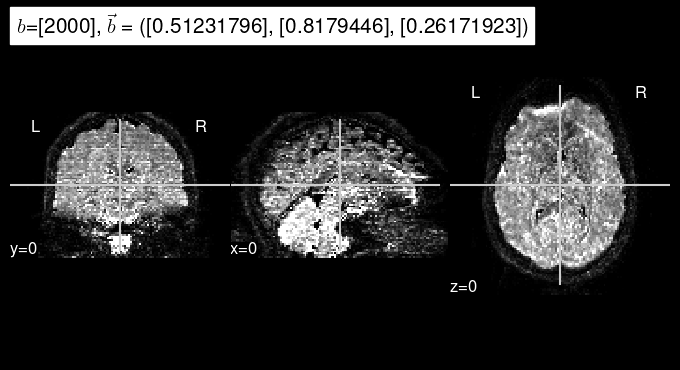

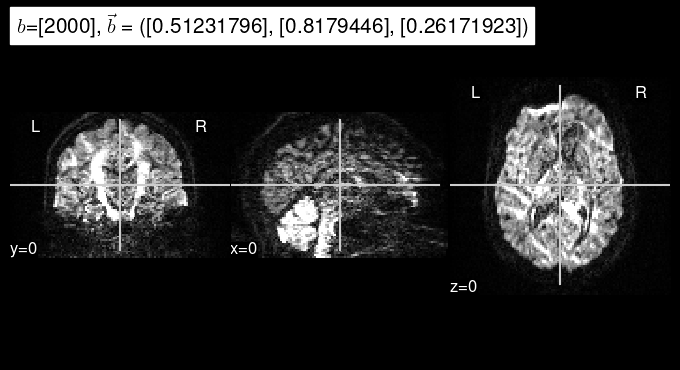

In [17]:
model.fit(data_train[0])
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);
plot_dwi(np.squeeze(data_test[0]), dmri_dataset.affine, gradient=data_test[1]);

## Next steps: image registration

Once we have our model factory readily available, it will be easy to generate predictions that we can use for reference in image registration.